<h1>loading</h1>

In [1]:
setwd("/staging/leuven/stg_00041/Bradley/")

library(umap)
library(ggplot2)
library(Seurat)
library(reshape2)
library(plyr)
library(dplyr)
library(gridExtra)
library(RColorBrewer)
library(ggpubr)
library(ggrepel)
library(viridis)


Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate


Loading required package: viridisLite



In [2]:
outFilePrefix <- "/data/leuven/343/vsc34313/jupyter_notebooks/integrateBlastoids/4.clustering.postFilter/filteredClusterGraphs/TPR+pasque/TPRpasque.filtered."

In [2]:
pasqueData <- readRDS("/lustre1/project/stg_00041/XuanAi/2020_2021/Naive_primed_TSCs/naive_primed_TSCs_VP_subset_filtered_mt_norm_20210916.rds")

In [4]:
load( "tyserPetRivron.combinedCountsSeuratReintegrated.filtered.Robject")


In [5]:
combinedCountsSeuratSplit <- SplitObject(combinedSeurat, split.by="study")

In [6]:
combinedCountsSeuratSplit$pasque <- pasqueData


In [16]:

#subsetting rivron to only include naive, primed, and 96h blastoids

combinedCountsSeuratSplit$rivron <- subset(combinedCountsSeuratSplit$rivron, subset = cellLineageOriginal%in%c("blastoid_96h_DN", "blastoid_96h_PDGFRa_pl", "blastoid_96h_TROP2_pl",
                                                                                                              "naive_H9", "primed_H9"))

<h1>integration</h1>

In [7]:

features <- SelectIntegrationFeatures(object.list=combinedCountsSeuratSplit)

anchors <- FindIntegrationAnchors(combinedCountsSeuratSplit, anchor.features=features)

combinedCountsSeuratReintegrated <- IntegrateData(anchorset=anchors, dims=1:50)

combinedCountsSeuratReintegrated <- ScaleData(combinedCountsSeuratReintegrated, verbose=FALSE)
combinedCountsSeuratReintegrated <- RunPCA(combinedCountsSeuratReintegrated, npcs=30, verbose=FALSE)

combinedCountsSeuratReintegrated <- FindNeighbors(combinedCountsSeuratReintegrated, reduction="pca", dims=1:30)

combinedCountsSeuratReintegrated <- suppressMessages(RunUMAP(combinedCountsSeuratReintegrated, reduction="pca", dims=1:30, seed.use = 123))


Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3294 anchors

Filtering anchors

	Retained 2697 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 3415 anchors

Filtering anchors

	Retained 2495 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2705 anchors

Filtering anchors

	Retained 1597 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2806 anchors

Filtering anchors

	Retained 1695 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2615 anchors

Filtering anchors

	Retained 1311 anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 2480 anchors

Filtering anchors

	Retained 1528 anchors

Merging dataset 4 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weight

In [8]:
lineageCenters <- function(combinedSeurat){
    lineageCenters <- data.frame(lineage=unique(combinedSeurat@meta.data$finalLabels), UMAP1=NA, UMAP2=NA)
    for(i in 1:nrow(lineageCenters)){
        lineageCenters$UMAP1[i] <- mean(combinedSeurat@reductions$umap@cell.embeddings[which(
            combinedSeurat@meta.data$finalLabels==lineageCenters$lineage[i]),1], na.rm=T)
        lineageCenters$UMAP2[i] <- mean(combinedSeurat@reductions$umap@cell.embeddings[which(
            combinedSeurat@meta.data$finalLabels==lineageCenters$lineage[i]),2], na.rm=T)
    }
    
    return(lineageCenters)
}

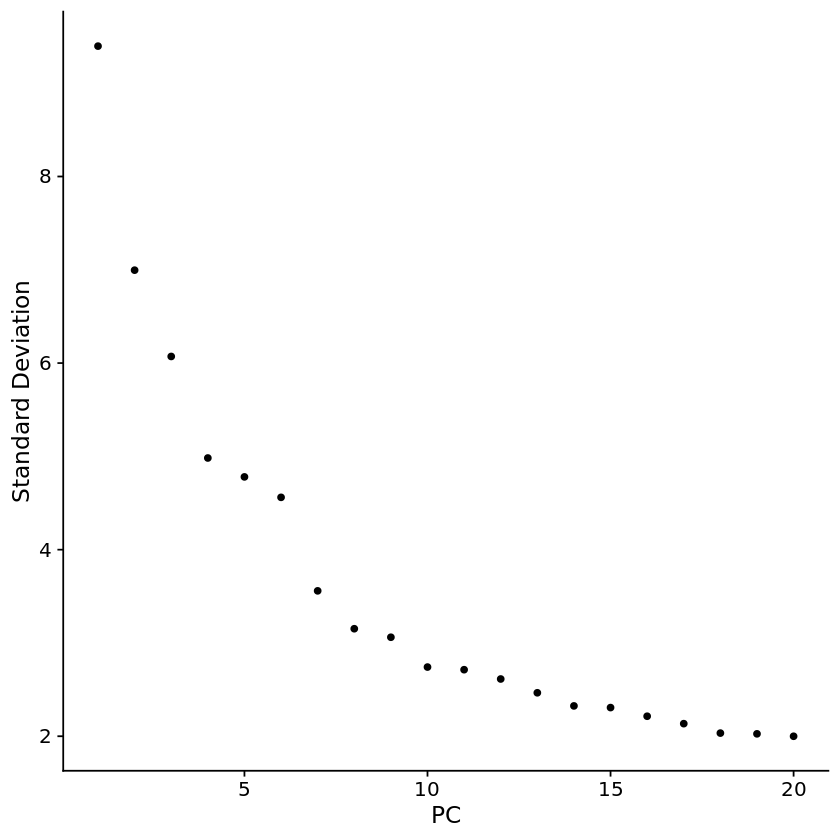

In [9]:
ElbowPlot(combinedCountsSeuratReintegrated)

In [10]:
combinedCountsSeuratReintegrated <- suppressMessages(RunUMAP(combinedCountsSeuratReintegrated, reduction="pca", dims=1:30, seed.use = 123, ))


In [12]:
combinedCountsSeuratReintegrated.lineageCenters <- lineageCenters(combinedCountsSeuratReintegrated)

ERROR: Error in data.frame(lineage = unique(combinedSeurat@meta.data$finalLabels), : arguments imply differing number of rows: 0, 1


In [ ]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings), aes(x=UMAP_1, y=UMAP_2, color=combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal))+
geom_point()+
theme(legend.position="bottom")+
geom_text_repel(data=combinedCountsSeuratReintegrated.lineageCenters,
                  aes(x=UMAP1, y=UMAP2, label=lineage), face="bold", size=6, color="black")+
guides(colour = guide_legend(override.aes = list(size=8)))+theme(text=element_text(size=18))


In [48]:
combinedCountsSeuratReintegrated@meta.data$cellLineage[which(is.na(combinedCountsSeuratReintegrated@meta.data$cellLineage) & !is.na(combinedCountsSeuratReintegrated@meta.data$Cell.type))] <- combinedCountsSeuratReintegrated@meta.data$Cell.type[which(is.na(combinedCountsSeuratReintegrated@meta.data$cellLineage) & !is.na(combinedCountsSeuratReintegrated@meta.data$Cell.type))]
combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal[which(is.na(combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal) & !is.na(combinedCountsSeuratReintegrated@meta.data$Cell.type))] <- combinedCountsSeuratReintegrated@meta.data$Cell.type[which(is.na(combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal) & !is.na(combinedCountsSeuratReintegrated@meta.data$Cell.type))]

In [27]:
#changing pasque annotations to match mine for cellLineage
combinedCountsSeuratReintegrated@meta.data$cellLineage[which(combinedCountsSeuratReintegrated@meta.data$cellLineage=="TSC")] <- "TB"
combinedCountsSeuratReintegrated@meta.data$cellLineage[which(combinedCountsSeuratReintegrated@meta.data$cellLineage=="primed_VP")] <- "primed"
combinedCountsSeuratReintegrated@meta.data$cellLineage[which(combinedCountsSeuratReintegrated@meta.data$cellLineage=="undefined")] <- "mesoderm"
combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal[which(combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal=="naive" & combinedCountsSeuratReintegrated@meta.data$study=="pasque")] <- "naive_VP"



In [28]:
lineageCenters <- function(combinedSeurat){
    lineageCenters <- data.frame(lineage=unique(combinedSeurat@meta.data$cellLineageOriginal), UMAP1=NA, UMAP2=NA)
    for(i in 1:nrow(lineageCenters)){
        lineageCenters$UMAP1[i] <- mean(combinedSeurat@reductions$umap@cell.embeddings[which(
            combinedSeurat@meta.data$cellLineageOriginal==lineageCenters$lineage[i]),1], na.rm=T)
        lineageCenters$UMAP2[i] <- mean(combinedSeurat@reductions$umap@cell.embeddings[which(
            combinedSeurat@meta.data$cellLineageOriginal==lineageCenters$lineage[i]),2], na.rm=T)
    }
    
    return(lineageCenters)
}

<h1>Manual Clustering</h1>

In [182]:
#manualClustering
combinedCountsSeuratReintegrated <- FindNeighbors(combinedCountsSeuratReintegrated , dims = 1:20)
combinedCountsSeuratReintegrated <- FindClusters(combinedCountsSeuratReintegrated , resolution = 0.6)


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4402
Number of edges: 166867

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8885
Number of communities: 16
Elapsed time: 0 seconds


Warning message:
"Ignoring unknown parameters: face"
Warning message:
"Removed 1 rows containing missing values (geom_text)."


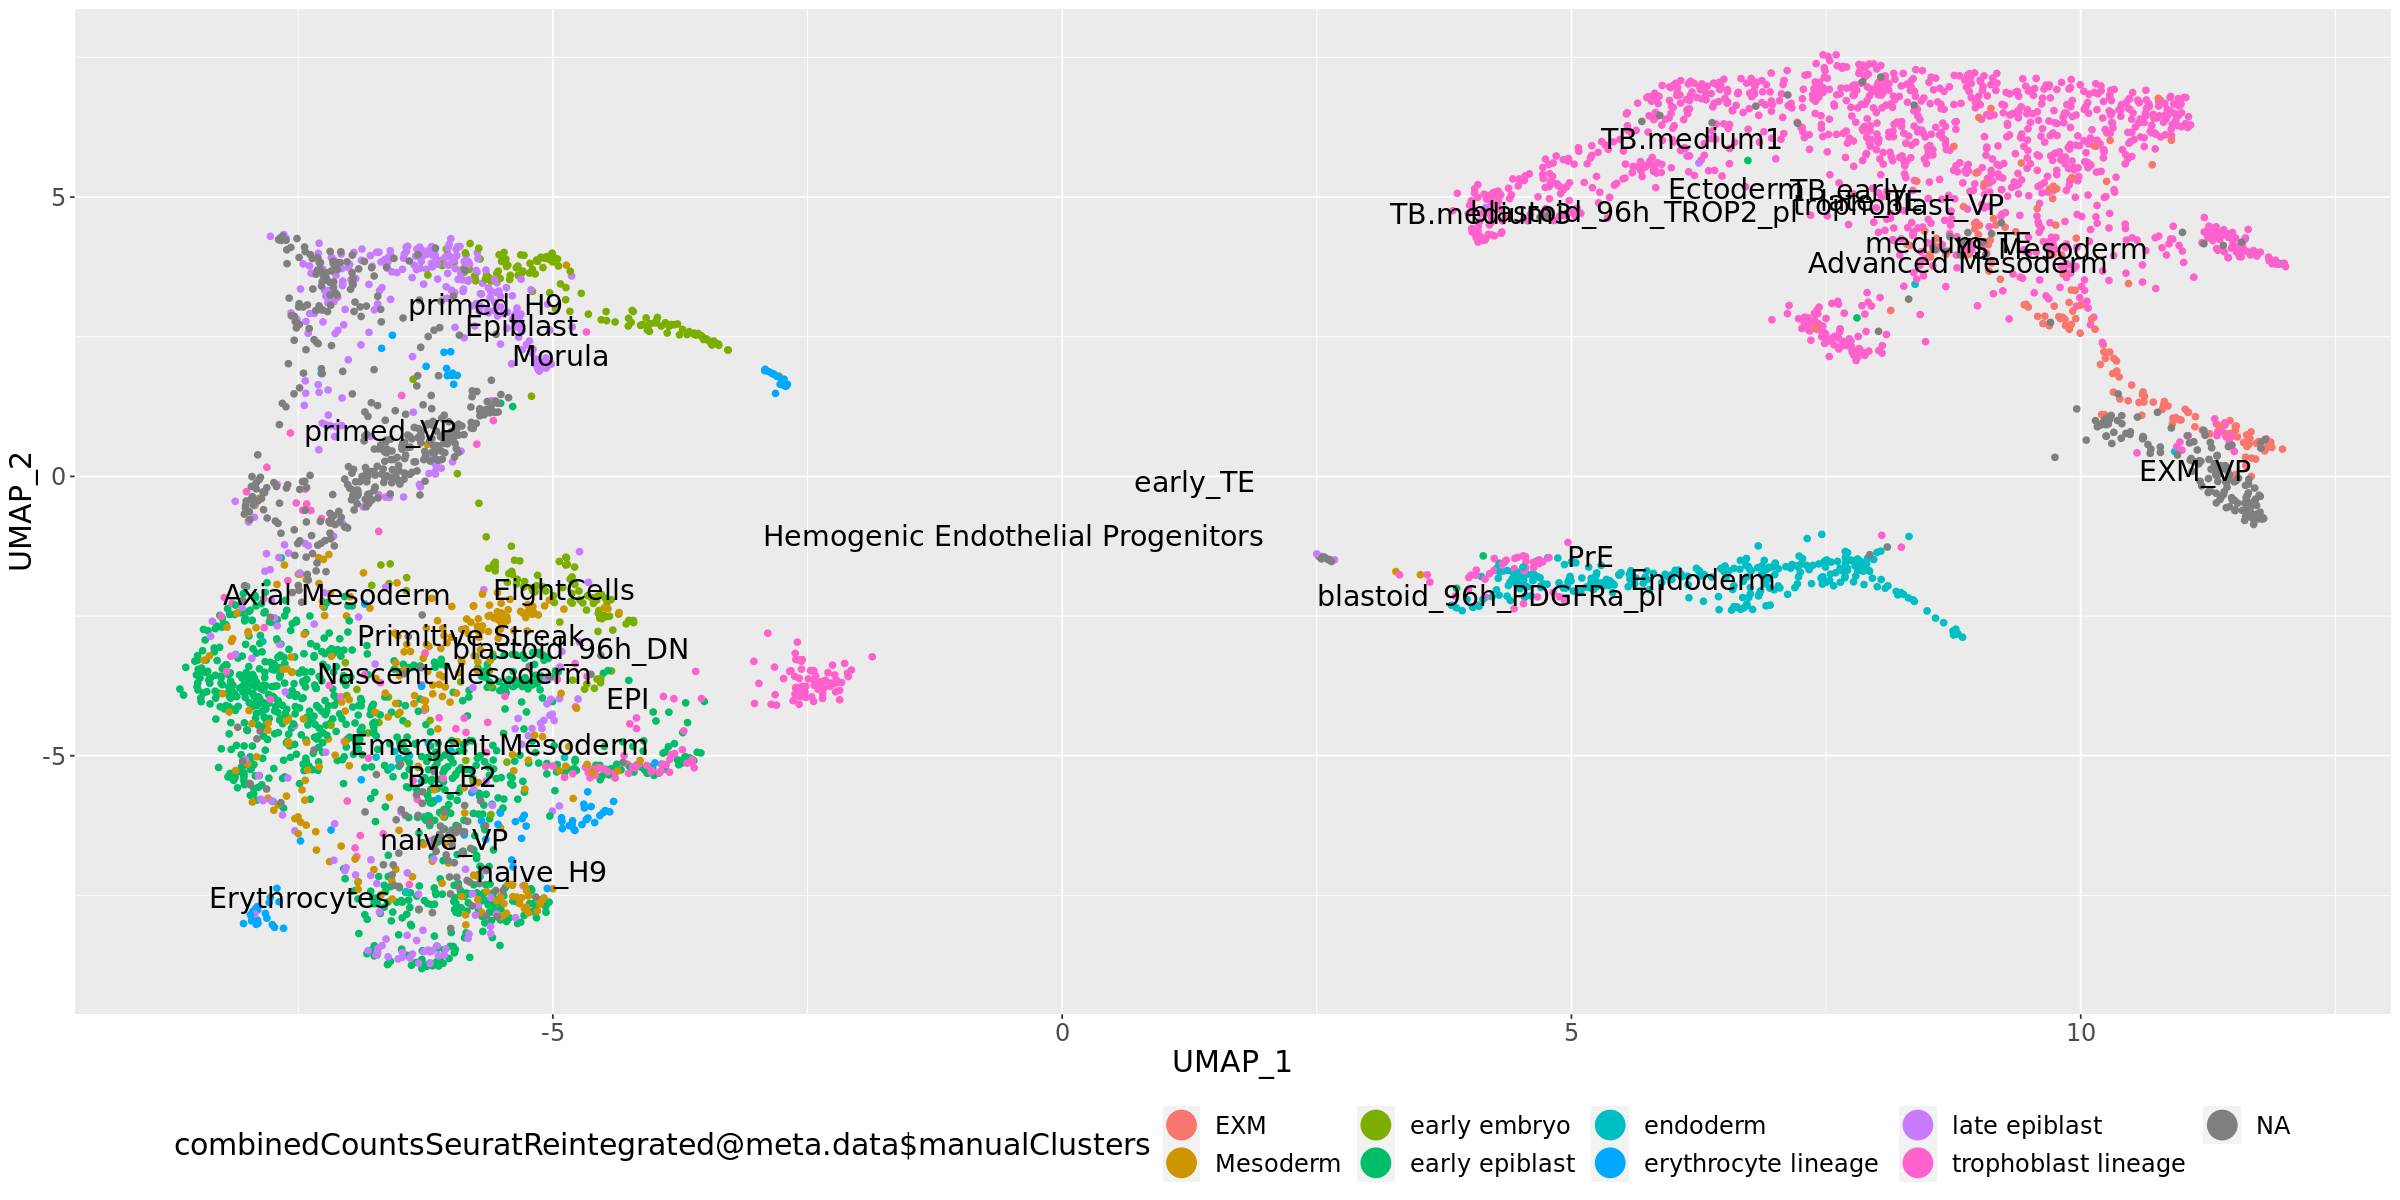

In [32]:
options(repr.plot.width=20, repr.plot.height=10)
ggplot(data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings), aes(x=UMAP_1, y=UMAP_2, color=combinedCountsSeuratReintegrated@meta.data$manualClusters))+
geom_point()+
theme(legend.position="bottom")+
geom_text(data=combinedCountsSeuratReintegrated.lineageCenters,
                  aes(x=UMAP1, y=UMAP2, label=lineage), face="bold", size=6, color="black")+
guides(colour = guide_legend(override.aes = list(size=8)))+theme(text=element_text(size=18))


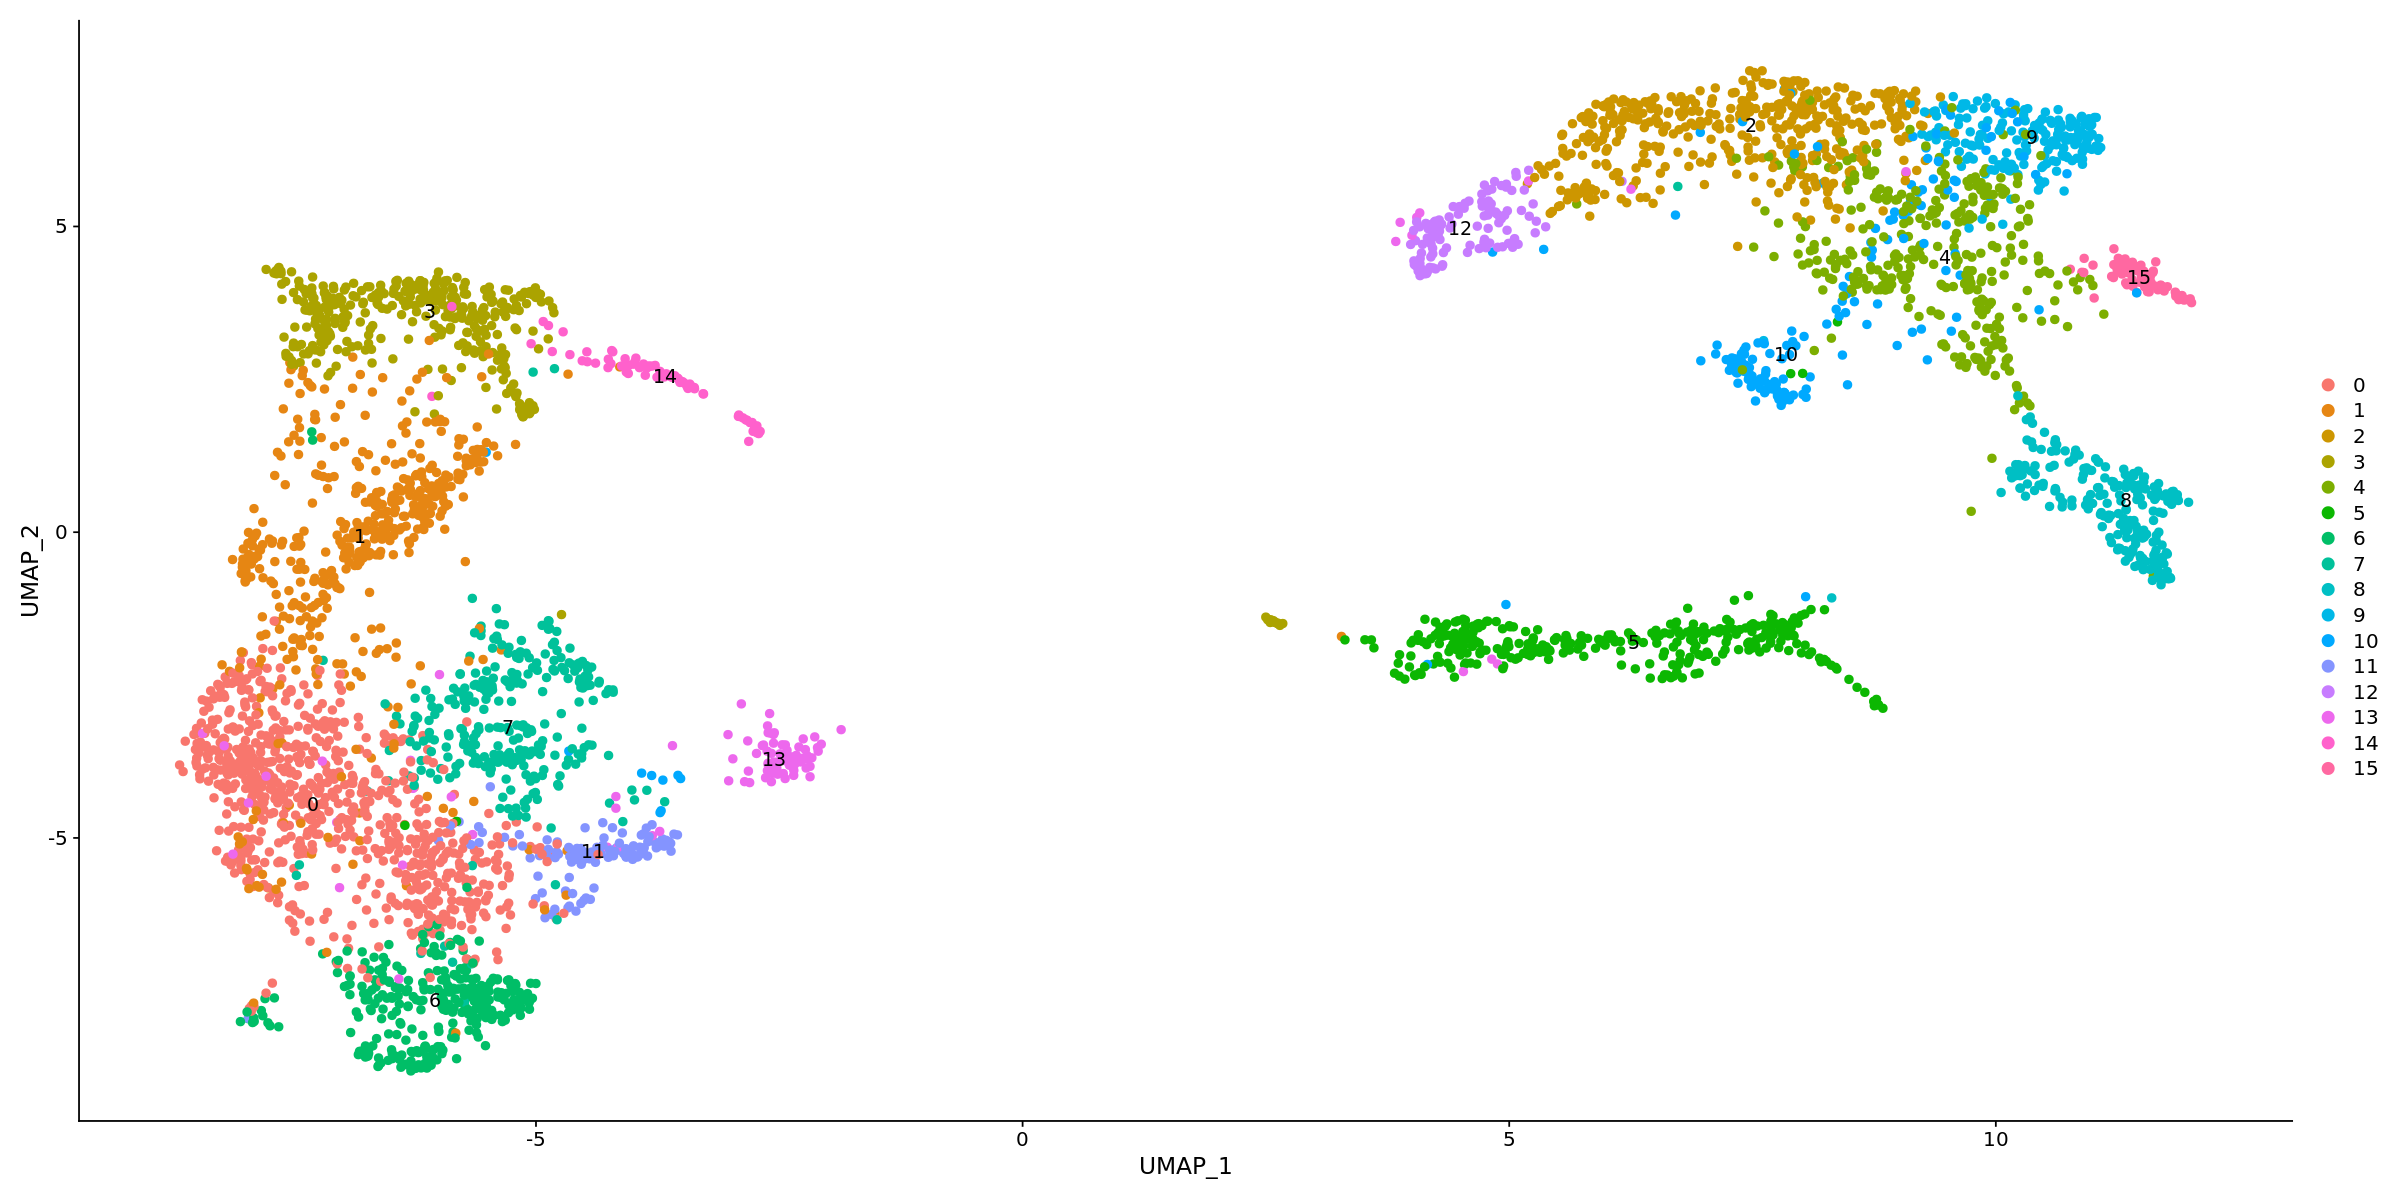

In [33]:
options(repr.plot.width=20, repr.plot.height=10)   
DimPlot(combinedCountsSeuratReintegrated, reduction = "umap", pt.size = 2, label = T)

In [20]:
rivronSeurat <- readRDS("/staging/leuven/stg_00041/Bradley/rivronData/rivron.seurat.rds")

In [49]:
combinedCountsSeuratReintegrated@meta.data$finalLabels <- combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal

In [50]:
combinedCountsSeuratReintegrated$finalLabels[which(combinedCountsSeuratReintegrated@meta.data$cell%in%rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data$manualClusters=="epiblast")])] <- "blastoid epiblast"
combinedCountsSeuratReintegrated$finalLabels[which(combinedCountsSeuratReintegrated@meta.data$cell%in%rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data$manualClusters=="primitive endoderm")])] <- "blastoid PE"
combinedCountsSeuratReintegrated$finalLabels[which(combinedCountsSeuratReintegrated@meta.data$cell%in%rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data$manualClusters=="trophectoderm")])] <- "blastoid TE"
combinedCountsSeuratReintegrated$finalLabels[which(combinedCountsSeuratReintegrated@meta.data$cell%in%rivronSeurat@meta.data$cell[which(rivronSeurat@meta.data$manualClusters=="exta-embyronic mesoderm")])] <- "blastoid EXM"

In [51]:
combinedCountsSeuratReintegrated@meta.data$finalLabels[which(combinedCountsSeuratReintegrated@meta.data$finalLabels=="TSC")] <- "TSC_VP"

In [53]:
lineageCenters <- function(combinedSeurat){
    lineageCenters <- data.frame(lineage=unique(combinedSeurat@meta.data$finalLabels), UMAP1=NA, UMAP2=NA)
    for(i in 1:nrow(lineageCenters)){
        lineageCenters$UMAP1[i] <- mean(combinedSeurat@reductions$umap@cell.embeddings[which(
            combinedSeurat@meta.data$finalLabels==lineageCenters$lineage[i]),1], na.rm=T)
        lineageCenters$UMAP2[i] <- mean(combinedSeurat@reductions$umap@cell.embeddings[which(
            combinedSeurat@meta.data$finalLabels==lineageCenters$lineage[i]),2], na.rm=T)
    }
    
    return(lineageCenters)
}

finalLabels.centers <- lineageCenters(combinedCountsSeuratReintegrated)

In [50]:
jpeg(paste(c( outFilePrefix, ".integration.allShown.jpeg"), collapse=""), width=1920, height=1080)
ggplot(data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings), aes(x=UMAP_1, y=UMAP_2))+
geom_point(data=data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings, 
                                       lineage=combinedCountsSeuratReintegrated@meta.data$finalLabels,
                                      study=combinedCountsSeuratReintegrated@meta.data$study), 
                 aes(x=UMAP_1, y=UMAP_2, color=lineage), size=0.75)+
theme(legend.position="bottom")+
geom_text_repel(data=finalLabels.centers,
                  aes(x=UMAP1, y=UMAP2, label=lineage), face="bold", size=6, color="black")+
guides(colour = guide_legend(override.aes = list(size=8)))+theme(text=element_text(size=18))


dev.off()


Warning message:
"Ignoring unknown parameters: face"
Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."


png 
  2

In [ ]:
qual_col_pals = brewer.pal.info[brewer.pal.info$category == "qual",]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))

col_vector<- sample(col_vector, replace = F)

In [52]:
names(col_vector) <- col_vector

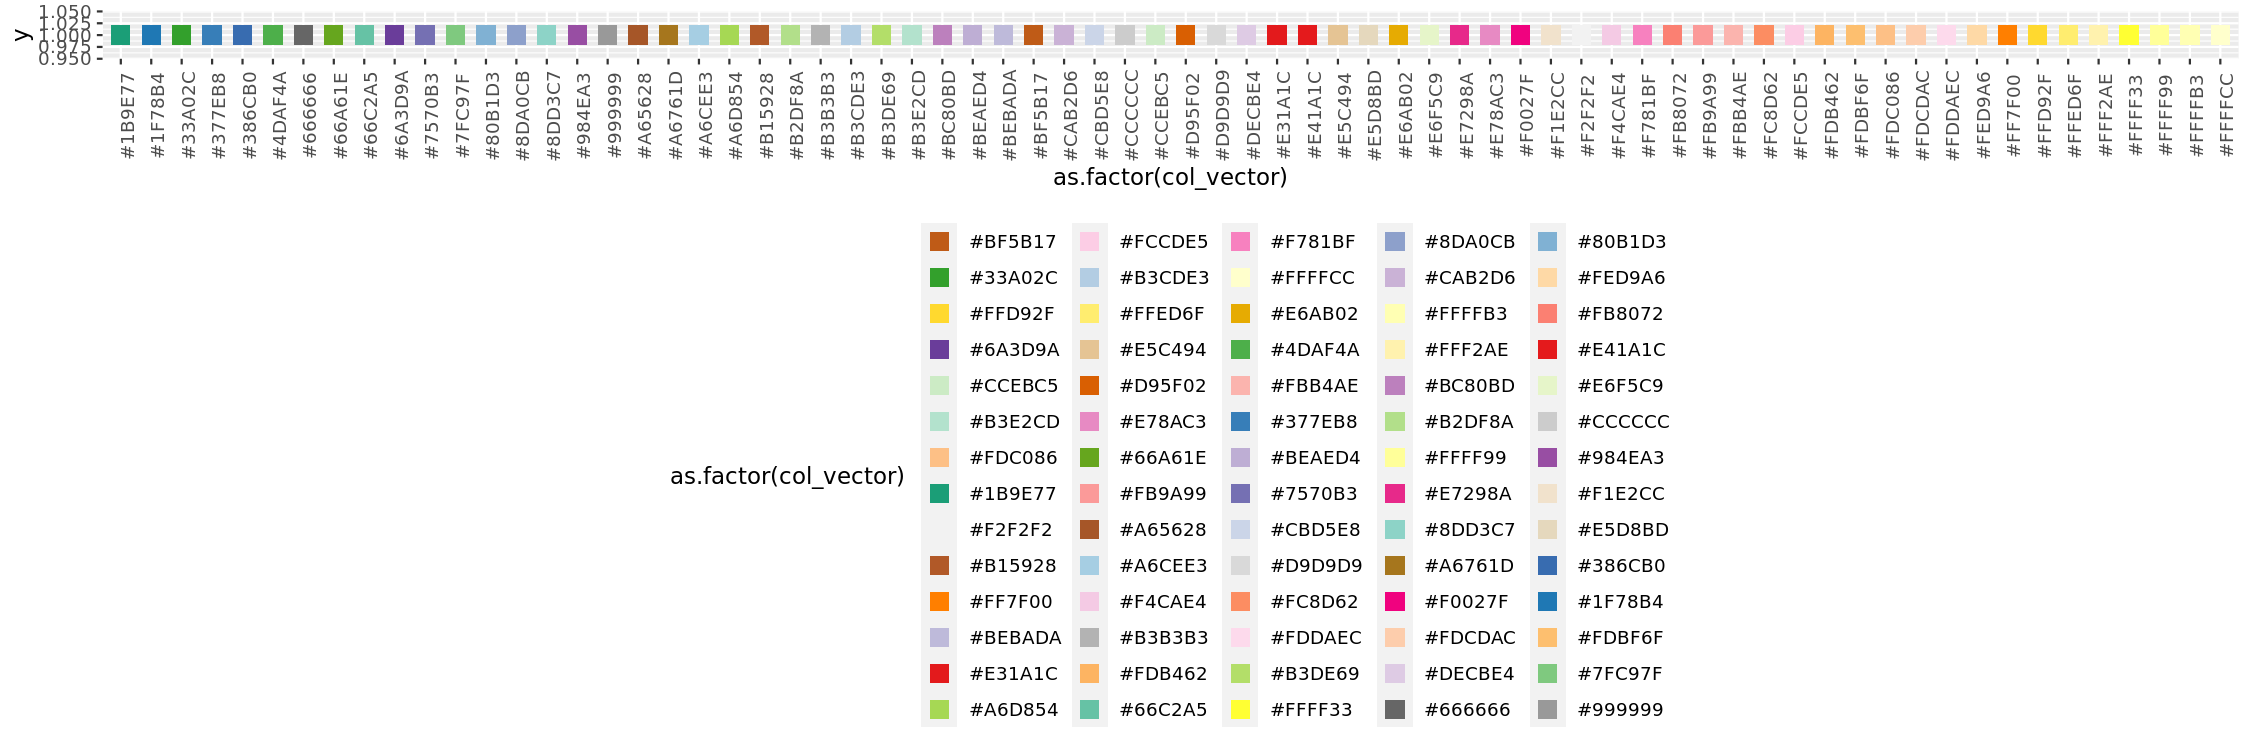

In [53]:
options(repr.plot.width = 15, repr.plot.height = 5, repr.plot.res = 150)
names(col_vector) <- col_vector
ggplot(data.frame(col_vector), aes(x=as.factor(col_vector), y=1, color=as.factor(col_vector)))+geom_point(shape=15, size=4)+theme(axis.text.x = element_text(angle=90), legend.position = "bottom")+
scale_color_manual(values=col_vector)
names(col_vector) <- (NULL)

In [152]:
names(col_vector) <- (NULL)

Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."


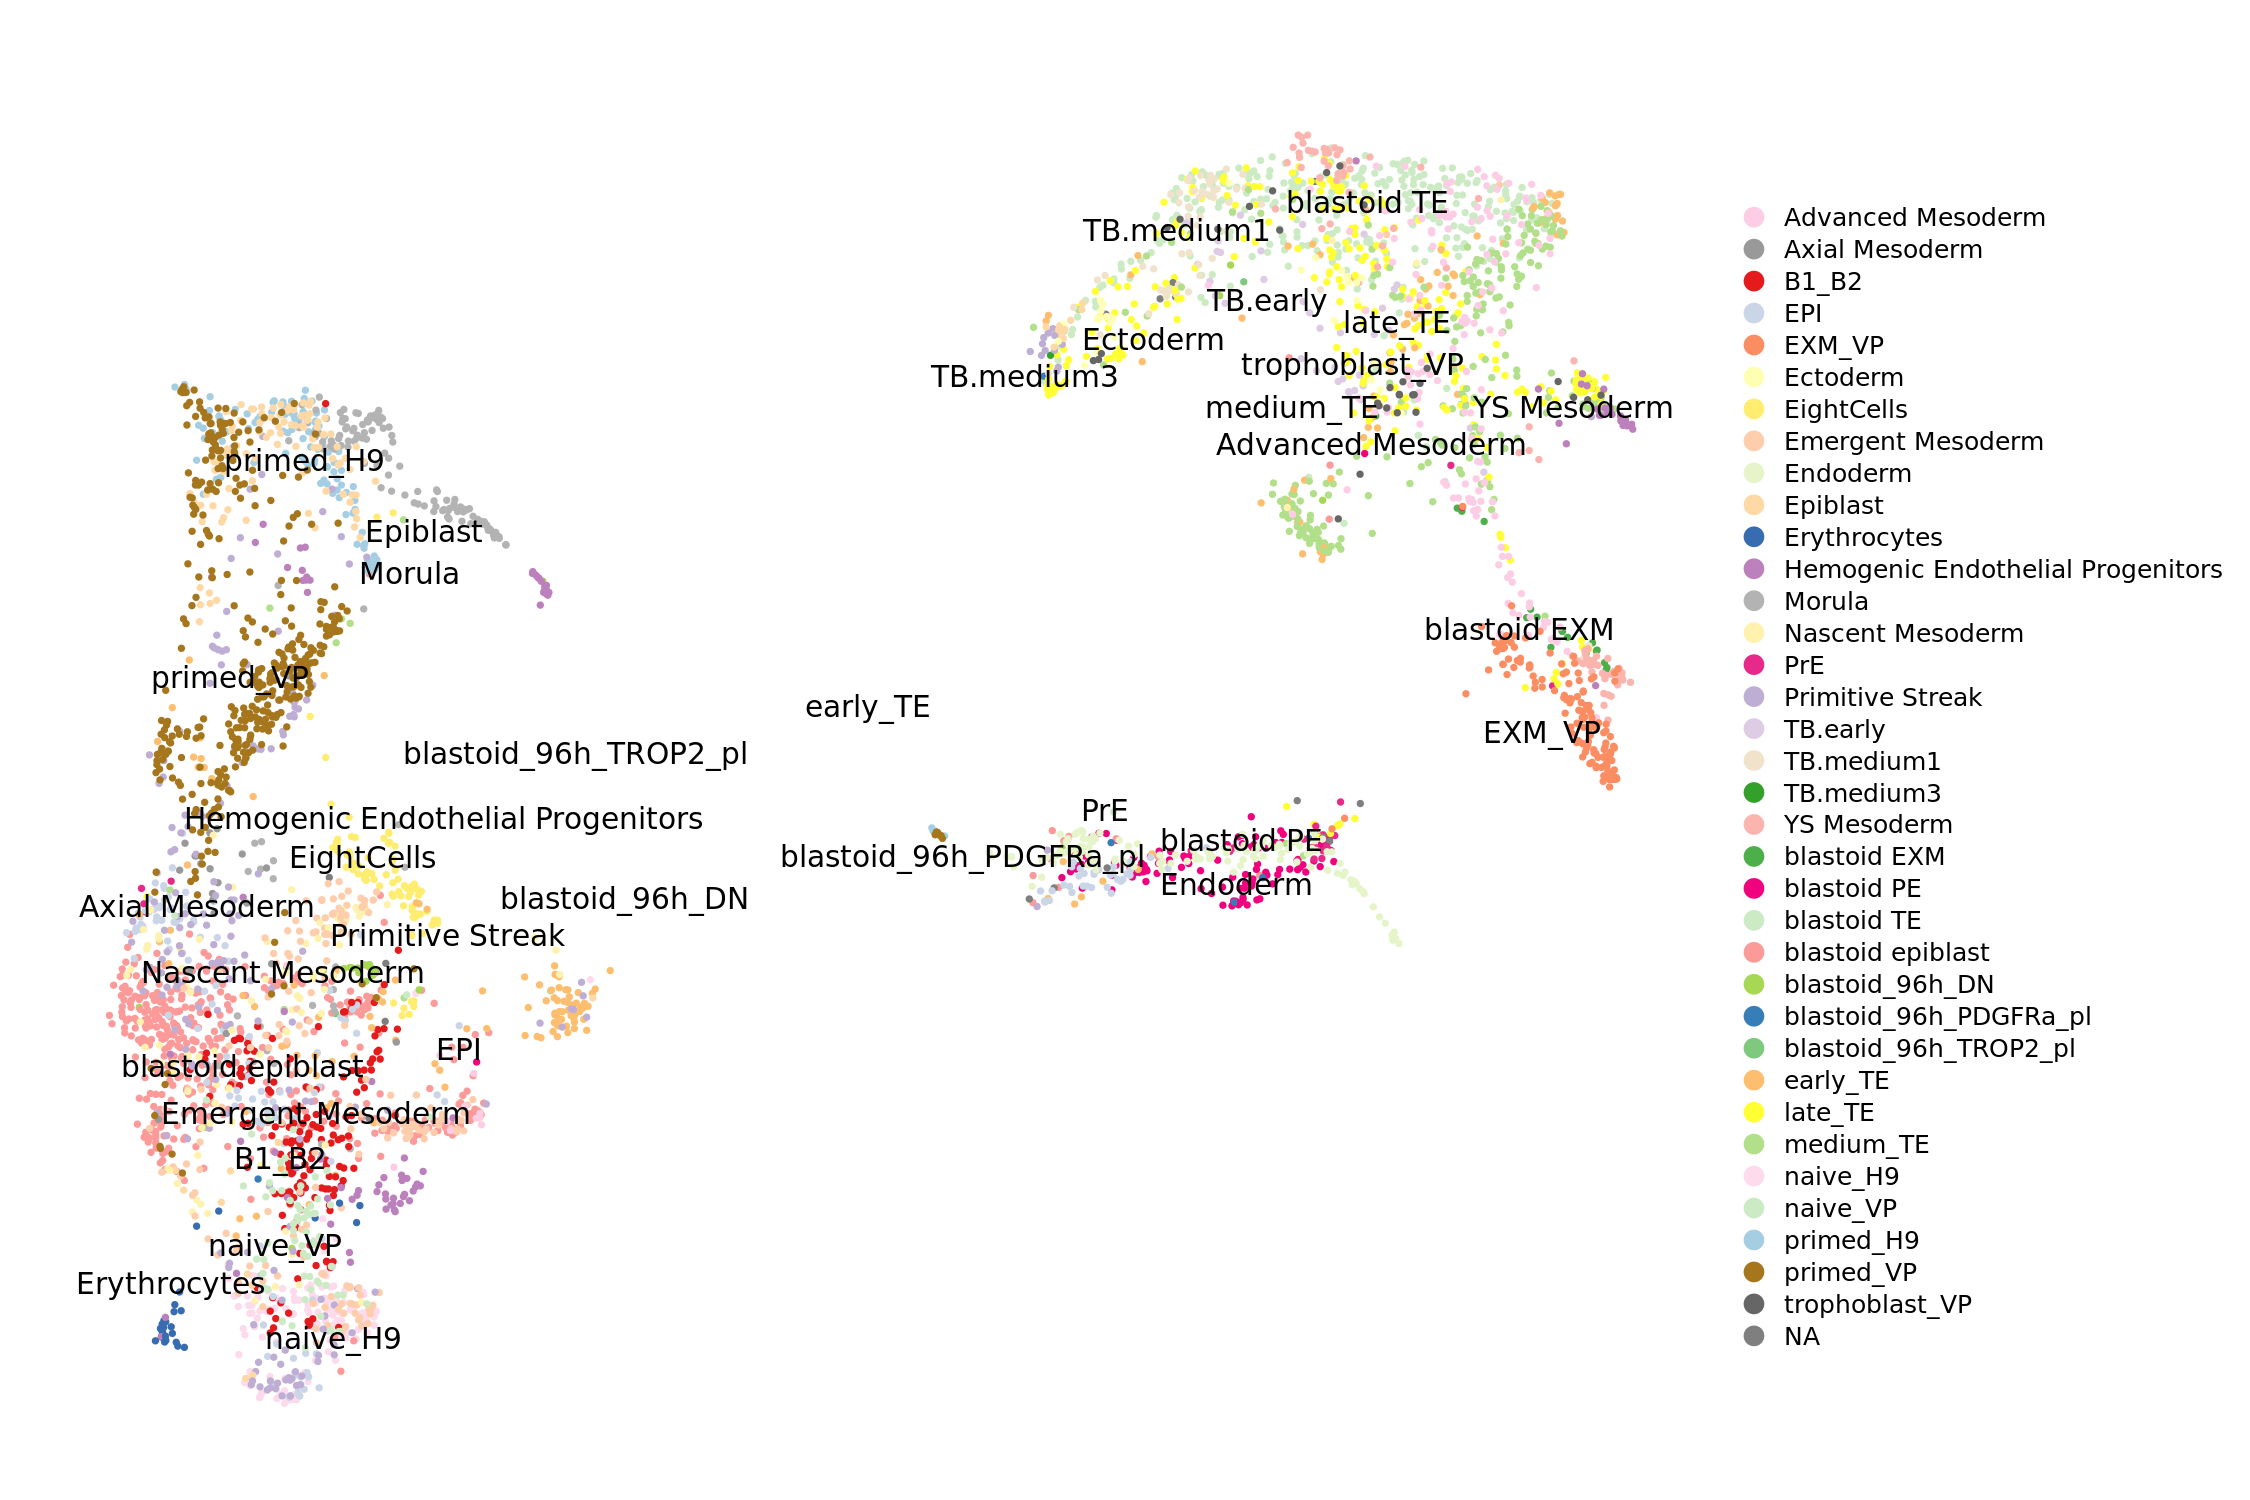

In [54]:
options(repr.plot.width = 15, repr.plot.height = 10, repr.plot.res = 150)

#jpeg(paste(c( outFilePrefix, ".allCells.Labeled.jpeg"), collapse=""), width=1200, height=600)
DimPlot(combinedCountsSeuratReintegrated, reduction = "umap", group.by = "finalLabels", pt.size =1, cols = c(col_vector))+
geom_text_repel(data=finalLabels.centers, aes(x=UMAP1, y=UMAP2, label=lineage),  size=5, color="black", max.overlaps = 15)+
theme(legend.position="right", axis.line = element_blank(), axis.text  = element_blank(), panel.border = element_blank(), 
      axis.ticks = element_blank())+ggtitle("")+guides(color=guide_legend(ncol=1,override.aes = list(size=4)))+
xlab(NULL)+ylab(NULL)
#dev.off()


<h3>Changing labels</h3>

In [7]:
changeLabels <- read.table("/staging//leuven/stg_00041/Bradley/EXMpaper.changeLabels.tsv", sep="\t", h=T)

In [8]:
unique(changeLabels$study)
unique(combinedCountsSeuratReintegrated@meta.data$study)

[1] "rivron"      "petropolous" "tyser"       "pasque"

[1] "rivron"      "petropolous" "tyser"       "pasque"

In [9]:
for(i in 1:nrow(changeLabels)){
        combinedCountsSeuratReintegrated@meta.data$finalLabels[which(combinedCountsSeuratReintegrated@meta.data$finalLabels==changeLabels$currLabels[i] & 
                                                                     combinedCountsSeuratReintegrated@meta.data$study==changeLabels$study[i])] <- 
    changeLabels$FinalLabels[i]
    
}

In [10]:
lineageCenters <- function(combinedSeurat){
    lineageCenters <- data.frame(lineage=unique(combinedSeurat@meta.data$finalLabels), UMAP1=NA, UMAP2=NA)
    for(i in 1:nrow(lineageCenters)){
        lineageCenters$UMAP1[i] <- mean(combinedSeurat@reductions$umap@cell.embeddings[which(
            combinedSeurat@meta.data$finalLabels==lineageCenters$lineage[i]),1], na.rm=T)
        lineageCenters$UMAP2[i] <- mean(combinedSeurat@reductions$umap@cell.embeddings[which(
            combinedSeurat@meta.data$finalLabels==lineageCenters$lineage[i]),2], na.rm=T)
    }
    
    return(lineageCenters)
}

finalLabels.centers <- lineageCenters(combinedCountsSeuratReintegrated)

In [59]:
options(repr.plot.width=25, repr.plot.height=30)
pdf(paste(c( outFilePrefix, ".integration.allShown.pdf"), collapse=""), width=8.3, height=6)
ggplot(data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings), aes(x=UMAP_1, y=UMAP_2))+
geom_point(data=data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings, 
                                       lineage=combinedCountsSeuratReintegrated@meta.data$finalLabels,
                                      study=combinedCountsSeuratReintegrated@meta.data$study), 
                 aes(x=UMAP_1, y=UMAP_2, color=lineage), size=0.75)+
theme(legend.position="right")+
geom_text_repel(data=finalLabels.centers,
                  aes(x=UMAP1, y=UMAP2, label=lineage),  size=3, color="black")+theme_linedraw()+
guides(colour = guide_legend(override.aes = list(size=2), ncol=1))+
theme(text=element_text(size=7), panel.grid = element_blank(), axis.ticks = element_blank(), axis.text=element_blank(), axis.line = element_blank(), panel.border = element_blank())+
xlab("")+ylab("")+scale_color_manual(values=col_vector)


dev.off()

Warning message:
"Removed 1 rows containing missing values (geom_text_repel)."


png 
  2

In [6]:
graphSpecificLineage <- function(lineageToGraph, outname, custColor=col_vector, colorLabelRow=1){
    #jpeg(outname, width=1920, height=1080)#change text size to 18, override.aes size to 8
    pdf(outname, width=2, height=2, ) #also change text size back to 7, change override.aes size back to 1
    names(custColor)<- lineageToGraph
    
print(ggplot(data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings), aes(x=UMAP_1, y=UMAP_2))+
geom_point(data=data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings, 
                                       lineage=combinedCountsSeuratReintegrated@meta.data$finalLabels,
                                      study=combinedCountsSeuratReintegrated@meta.data$study), 
                 aes(x=UMAP_1, y=UMAP_2),color="grey", size=0.01)+
geom_point(data=data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings, 
                                       lineage=combinedCountsSeuratReintegrated@meta.data$finalLabels,
                                      study=combinedCountsSeuratReintegrated@meta.data$study)[which(combinedCountsSeuratReintegrated@meta.data$finalLabels%in%lineageToGraph),], 
                 aes(x=UMAP_1, y=UMAP_2, color=lineage), size=0.01)+
      theme_linedraw()+
theme(legend.position="bottom", panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
guides(colour = guide_legend(override.aes = list(size=1), nrow=colorLabelRow))+
      theme(text=element_text(size=7), axis.line = element_blank(), axis.text  = element_blank(), panel.border = element_blank(), axis.ticks = element_blank())+
      scale_color_manual(values=custColor, name=NULL)+xlab(NULL)+ylab(NULL)
)

dev.off()
}

In [59]:
graphSpecificLineage(outname = paste(c( outFilePrefix, ".integration.EXMonly.jpeg"), collapse=""), lineageToGraph = c("YS Mesoderm", "EXM_VP", "blastoid EXM"), custColor=c("#66A61E",  "#1F78B4","#E41A1C"))


png 
  2

In [113]:
graphSpecificLineage(outname = paste(c( outFilePrefix, ".integration.EXMonly.pdf"), collapse=""), lineageToGraph = c("Tyser YS Meso.","Tyser Adv. Meso.", "Pasque EXMC", "Blastoid EXMC"), custColor=c("#66A61E","#BC80BD" , "#1F78B4","#E41A1C"))
graphSpecificLineage(outname = paste(c( outFilePrefix, ".integration.PrEonly.pdf"), collapse=""), lineageToGraph = c("Pet. PE", "Tyser Endoderm", "Blastoid PE"), custColor=c("#1B9E77", "#377EB8", "#FB8072"))
graphSpecificLineage(outname = paste(c( outFilePrefix, ".integration.EPIonly.pdf"), collapse=""), lineageToGraph = c("Pet. Epiblast","Tyser Epiblast", "Blastoid Epiblast"), custColor=c("#33A02C","#8DA0CB", "#FB8072" ))


graphSpecificLineage(outname = paste(c( outFilePrefix, ".integration.TEonly.pdf"), collapse=""), lineageToGraph = c("Pet. Early TE", "Pet. Med. TE", "Pet. Late TE", "Pet. Early TB","Pet. Med. TB", "Pasque Trophoblast",  "Blastoid TE"),
                    custColor=c(brewer.pal(n = 8, name = "Blues")[c(4:8)], "#E7298A", "#E31A1C"), colorLabelRow=2)


png 
  2

png 
  2

png 
  2

png 
  2

In [29]:
combinedCountsSeuratReintegrated@meta.data$finalLabels[which(combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal=="naive_H9")] <-"Kagawa Naive"

In [30]:
graphSpecificLineage(outname = paste(c( outFilePrefix, ".integration.TyserEXMC.pdf"), collapse=""), 
                     lineageToGraph = c("Tyser YS Meso."), custColor=c("#66A61E"))
graphSpecificLineage(outname = paste(c( outFilePrefix, ".integration.TyserAdvMeso.pdf"), collapse=""), 
                     lineageToGraph = c("Tyser Adv. Meso."), custColor=c("#BC80BD" ))
graphSpecificLineage(outname = paste(c( outFilePrefix, ".integration.PAsqueEXMC.pdf"), collapse=""), 
                     lineageToGraph = c( "Pasque EXMC"), custColor=c( "#1F78B4"))
graphSpecificLineage(outname = paste(c( outFilePrefix, ".integration.blastoidEXMConly.pdf"), collapse=""), 
                     lineageToGraph = c("Blastoid EXMC"), custColor=c("#E41A1C"))


png 
  2

png 
  2

png 
  2

png 
  2

In [25]:
pdf(paste(c( outFilePrefix, ".integration.naive.pdf"), collapse=""), width=2, height=2, )
ggplot(data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings), aes(x=UMAP_1, y=UMAP_2))+
geom_point(data=data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings, 
                                       lineage=combinedCountsSeuratReintegrated@meta.data$finalLabels,
                                      study=combinedCountsSeuratReintegrated@meta.data$study), 
                 aes(x=UMAP_1, y=UMAP_2),color="grey", size=0.01)+
geom_point(data=data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings, 
                                       lineage=combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal,
                                      study=combinedCountsSeuratReintegrated@meta.data$study)[which(combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal%in%c('naive_H9')),], 
                 aes(x=UMAP_1, y=UMAP_2, color=lineage), size=0.01)+
      theme_linedraw()+
theme(legend.position="bottom", panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
guides(colour = guide_legend(override.aes = list(size=1), nrow=1))+
      theme(text=element_text(size=7), axis.line = element_blank(), axis.text  = element_blank(), panel.border = element_blank(), axis.ticks = element_blank())
dev.off()

png 
  2

In [31]:
graphEXMC <- function(lineageToGraph, outname, custColor=col_vector, colorLabelRow=1){
    #jpeg(outname, width=1920, height=1080)#change text size to 18, override.aes size to 8
    pdf(outname, width=2, height=2, ) #also change text size back to 7, change override.aes size back to 1
    names(custColor)<- lineageToGraph
    
print(ggplot(data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings), aes(x=UMAP_1, y=UMAP_2))+
geom_point(data=data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings, 
                                       lineage=combinedCountsSeuratReintegrated@meta.data$finalLabels,
                                      study=combinedCountsSeuratReintegrated@meta.data$study), 
                 aes(x=UMAP_1, y=UMAP_2),color="grey", size=0.01)+
geom_point(data=data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings, 
                                       lineage=combinedCountsSeuratReintegrated@meta.data$finalLabels,
                                      study=combinedCountsSeuratReintegrated@meta.data$study)[which(combinedCountsSeuratReintegrated@meta.data$finalLabels%in%lineageToGraph),], 
                 aes(x=UMAP_1, y=UMAP_2, color=lineage), size=0.01)+
geom_point(data=data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings, 
                                       lineage=combinedCountsSeuratReintegrated@meta.data$finalLabels,
                                      study=combinedCountsSeuratReintegrated@meta.data$study)[which(combinedCountsSeuratReintegrated@meta.data$finalLabels%in%"Blastoid EXMC"),], 
                 aes(x=UMAP_1, y=UMAP_2, color=lineage), size=0.01)+
      theme_linedraw()+
theme(legend.position="bottom", panel.grid.major = element_blank(), panel.grid.minor = element_blank())+
guides(colour = guide_legend(override.aes = list(size=1), nrow=colorLabelRow))+
      theme(text=element_text(size=7), axis.line = element_blank(), axis.text  = element_blank(), panel.border = element_blank(), axis.ticks = element_blank())+
      scale_color_manual(values=custColor, name=NULL)+xlab(NULL)+ylab(NULL)
)

dev.off()
}

In [32]:
graphEXMC(outname = paste(c( outFilePrefix, ".integration.EXMonly.pdf"), collapse=""), lineageToGraph = c("Tyser YS Meso.","Tyser Adv. Meso.", "Pasque EXMC", "Blastoid EXMC"), custColor=c("#66A61E","#BC80BD" , "#1F78B4","#E41A1C"))

png 
  2

In [55]:
table(combinedCountsSeuratReintegrated@meta.data$finalLabels%in%c("Tyser YS Meso.","Tyser Adv. Meso.", "Pasque EXMC", "Blastoid EXMC"))


FALSE  TRUE 
 4005   397 

<h1>Define Features</h1>

In [71]:
combinedCountsSeuratReintegrated@meta.data$finalLabels[which(is.na(combinedCountsSeuratReintegrated@meta.data$finalLabels))] <- "unknown"
Idents(object=combinedCountsSeuratReintegrated) <- unique(combinedCountsSeuratReintegrated@meta.data$finalLabels)

In [ ]:
combinedCountsSeuratReintegrated@meta.data$finalLabelsBlastoidCondensed <- combinedCountsSeuratReintegrated@meta.data$finalLabels
combinedCountsSeuratReintegrated@meta.data$finalLabelsBlastoidCondensed[which(combinedCountsSeuratReintegrated@meta.data$finalLabels=="blastoid EXM")] <- "EXM"
combinedCountsSeuratReintegrated@meta.data$finalLabelsBlastoidCondensed[which(combinedCountsSeuratReintegrated@meta.data$finalLabels=="blastoid PE")] <- "PE"
combinedCountsSeuratReintegrated@meta.data$finalLabelsBlastoidCondensed[which(combinedCountsSeuratReintegrated@meta.data$finalLabels=="blastoid TE")] <- "TE"
combinedCountsSeuratReintegrated@meta.data$finalLabelsBlastoidCondensed[which(combinedCountsSeuratReintegrated@meta.data$finalLabels=="blastoid epiblast")] <- "Epi"

UMAPs colored by Expression

In [70]:
combinedCountsSeuratReintegrated@meta.data <- cbind(combinedCountsSeuratReintegrated@meta.data, data.frame(combinedCountsSeuratReintegrated@reductions$umap@cell.embeddings))

In [78]:
combinedCountsSeuratReintegrated@meta.data$cell[which(combinedCountsSeuratReintegrated$study=="pasque")] <- rownames(combinedCountsSeuratReintegrated@meta.data)[which(combinedCountsSeuratReintegrated$study=="pasque")]

In [69]:
load("integratedBlastoids.combinedCounts.raw.Robject")

In [163]:
genesOfInterest <- c("KLF17", "KLF4", "SUSD2", "DNMT3L", "POU5F1", "SOX2", "NANOG", "OTX2", "ZIC2", "POSTN", "VIM", "GATA2", "GATA3", "KRT7", "KRT18", "HAND1", "EOMES", "MIXL1", "CDX2", "MESP1", "SDC1", "CGA", "CGB3", "ISL1", "ANXA1")

In [72]:
genesOfInterest <- feats.EXM

In [172]:
for(i in genesOfInterest){
    jpeg(paste(c(outFilePrefix, "geneExpressionUMAPs/",i, "geneExpressionUMAP", ".plot.jpeg" ), collapse=""), width=260, height=210, pointsize = 150)
    print(ggplot(temp, aes(x=UMAP_1, y=UMAP_2, color=log10(eval(parse(text = i)))))+geom_point(size=1)+scale_color_viridis( na.value="black", guide="none")+
          theme_linedraw()+theme(panel.border = element_blank(), panel.grid = element_blank(), axis.text = element_blank(), axis.ticks=element_blank())+xlab("")+ylab(""))
    dev.off()
}

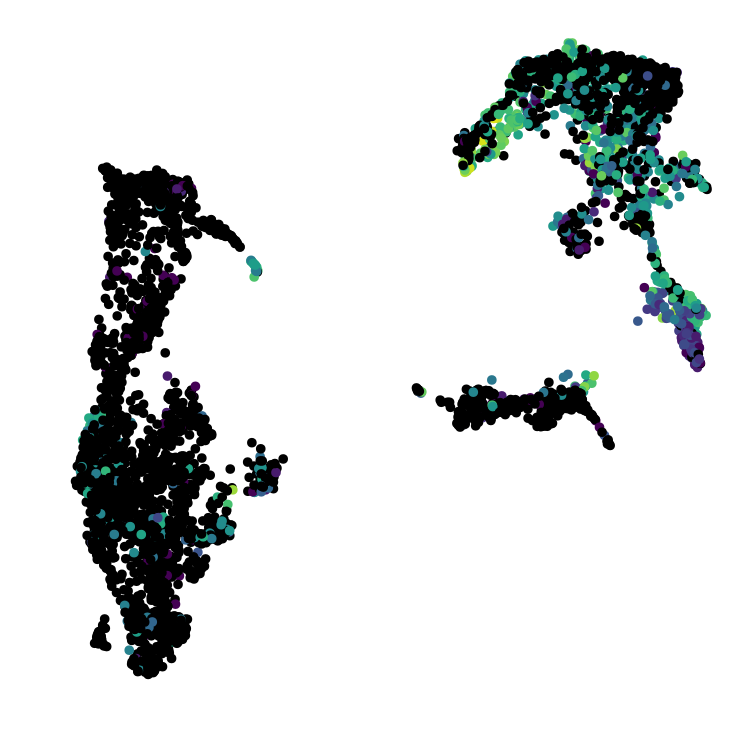

In [174]:
options(repr.plot.width=5, repr.plot.height=5)    

print(ggplot(temp, aes(x=UMAP_1, y=UMAP_2, color=log10(eval(parse(text = i)))))+geom_point()+scale_color_viridis( na.value="black", guide="none")+
          theme_linedraw()+theme(panel.border = element_blank(), panel.grid = element_blank(), axis.text = element_blank(), axis.ticks=element_blank())+xlab("")+ylab(""))

% blastoid cells per lineage

In [162]:
#graph % blastoids per cell type
nBlastoids <- table(combinedCountsSeuratReintegrated@meta.data$finalLabels[which(combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal%in%c("blastoid_96h_DN", "blastoid_96h_TROP2_pl", "blastoid_96h_PDGFRa_pl"))])
percentBlastoids <-round(table(combinedCountsSeuratReintegrated@meta.data$finalLabels[which(combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal%in%c("blastoid_96h_DN", "blastoid_96h_TROP2_pl", "blastoid_96h_PDGFRa_pl"))])/
length(which(combinedCountsSeuratReintegrated@meta.data$cellLineageOriginal%in%c("blastoid_96h_DN", "blastoid_96h_TROP2_pl", "blastoid_96h_PDGFRa_pl")))*100)

png 
  2

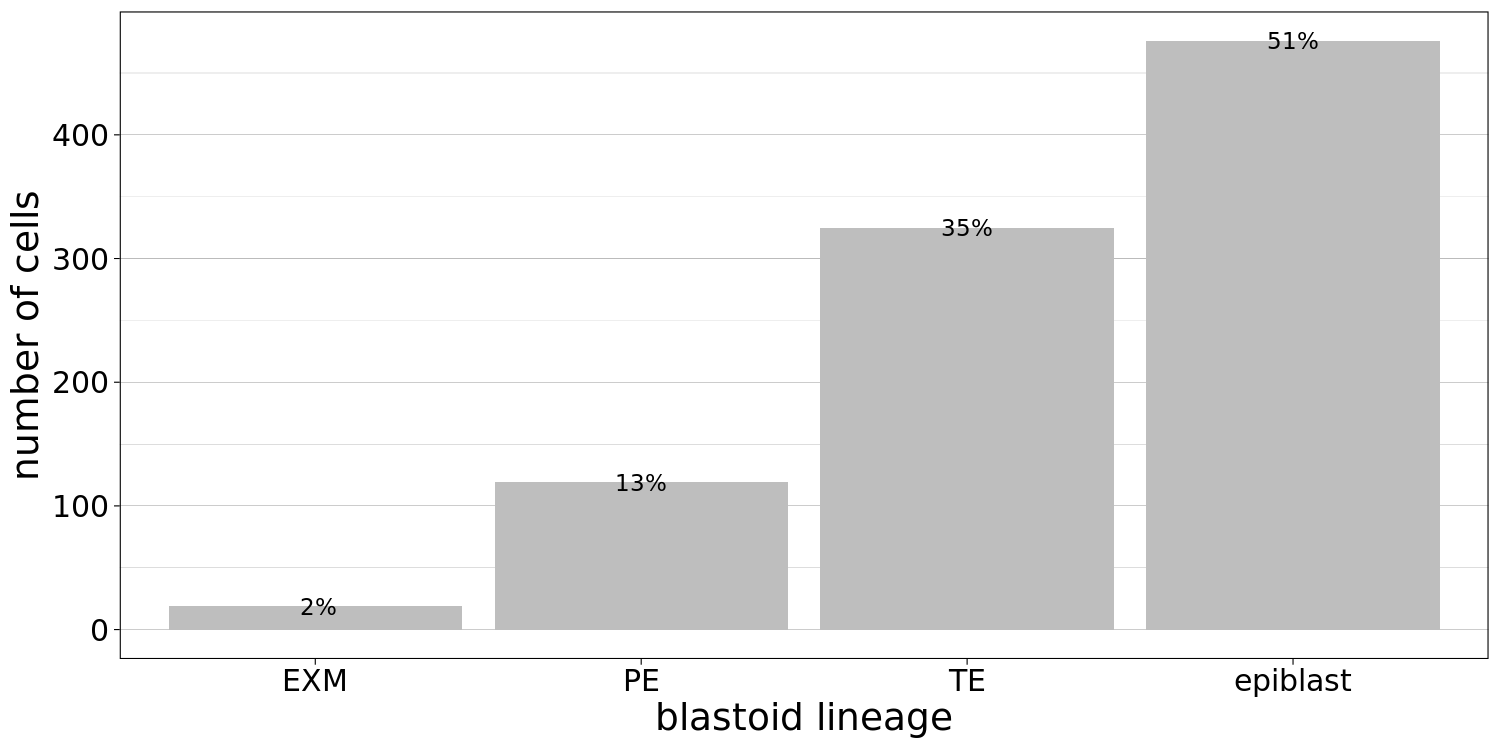

In [163]:
options(repr.plot.width=10, repr.plot.height=5)

pdf(paste(c(outFilePrefix, "blastoidDistribution.pdf" ), collapse=""), width=3, height=3)
ggplot(data.frame(type=c("EXM", "PE", "TE", "epiblast"), percentBlastoids=c(percentBlastoids), nBlastoids=apply(data.frame(c(nBlastoids), "cells"), 1, paste, collapse=" ")), aes(x=type, y=percentBlastoids, label=nBlastoids))+
geom_bar(stat="identity", fill="grey")+geom_text()+theme_linedraw()+
xlab("blastoid lineage")+ylab("percent of blastoids in lineage")+theme(text=element_text(size=18), panel.grid.major.x = element_blank())
dev.off()


ggplot(data.frame(type=c("EXM", "PE", "TE", "epiblast"), nBlastoids=c(nBlastoids), pBlastoids=apply(data.frame(c(percentBlastoids), "%"), 1, paste, collapse="")), 
       aes(x=type, y=nBlastoids, label=pBlastoids))+
geom_bar(stat="identity", fill="grey")+geom_text()+theme_linedraw()+
xlab("blastoid lineage")+ylab("number of cells")+theme(text=element_text(size=18), panel.grid.major.x = element_blank())




saving and load finished seurat object

In [ ]:
save(combinedCountsSeuratReintegrated, file="inegrate.PRTwPasqueEXM.Robject")

In [16]:
load("inegrate.PRTwPasqueEXM.Robject")

<h1>final version of heatmap (pre-submission)</h1>

In [3]:
feats.core <- c("POU5F1", "SOX2","NANOG")
feats.primed <- c("OTX2", "ZIC2", "CD24", "DUSP6", "TCF4")
feats.naive <- c("KLF17", "KLF4", "SUSD2", "DNMT3L", "DPPA5", "TFCP2L1")
feats.TE <- c("GATA2","GATA3","ITGA6","TP63","KRT7","KRT18","HAND1","NR2F2")
feats.EXMC <- c("LUM","NID2", "FOXF1", "VIM", "POSTN", "ANXA1")#,  "PITX1")#, "BST2", "DCN")
feats.PrE <- c("SOX17", "GATA4", "GATA6", "FOXA2", "PDGFRA","CDH2")
feats.EVT <- c("HLA-G", "MMP2", "ITGA5")
feats.STB <- c("CGA", "CGB3", "SDC1")
feats.amnion<- c("WNT6", "GABRP", "ISL1", "HEY1", "CDH10", "CTSV", "TPM1")
feats.mesoderm <- c("MIXL1", "MESP1", "ZIC3",  "T", "CDX1", "CDX2", "CDX4", "EOMES")

In [4]:
combinedFeats <- list(core=feats.core, primed=feats.primed, naive=feats.naive, trophectoderm=feats.TE, EXMC=feats.EXMC, PE=feats.PrE, EVT=feats.EVT, STB=feats.STB, amnin=feats.amnion, mesoderm=feats.mesoderm)

In [5]:

#plotting as a function, does  heatmap
plotHeatmap <- function(combinedSeurat, group.by="seurat_clusters", cellsToInclude=NA, save=F, feats=feats, outfile=NA, dMin=-2, dMax=2, onlyHeatMap=F, topTextAngle=45, text=T, pdfSize=c(8.3,5)){

    featNames=names(feats)
featLengths    <- numeric(length=length(feats))
featLengthsForward <- numeric(length=length(feats))
featLengthsReverse <- numeric(length=length(feats))
featsLinear <- NULL    
    
for(i in 1:length(feats)){
        feats[[i]] <- feats[[i]][which(!feats[[i]]%in%featsLinear)]
        featLengths[i] <- length(which(feats[[i]]%in%rownames(combinedSeurat)))
        featsLinear <- c(featsLinear, feats[[i]])

        featLengthsForward[i] <- sum(featLengths[1:(i)])+0.5

}
        
    #print(c(icmL,epiL,hypoL,teL,naiveL,primedL ))

    

feats <- featsLinear    
 
feats <- feats[which(feats%in%rownames(combinedSeurat) & !duplicated(feats))]
    
featLengthsReverse <- length(feats)-featLengthsForward+1
    
options(repr.plot.width=20, repr.plot.height=18)    

if(is.na(cellsToInclude)){
    if(ncol(combinedSeurat)>2000){
    groups <- unique(combinedSeurat@meta.data[,group.by])
    cells=c(1)
    
    for(i in groups){
        cells <- c(cells, sample(which(combinedSeurat@meta.data[,group.by]==i), 
                                 min(c(2000/length(groups), length(which(combinedSeurat@meta.data[,group.by]==i))))))
    }
    
    
    #in the future I should make this sample equal percent per lineage
    } else {
    cells=1:ncol(combinedSeurat)
    }
} else {
    cells=cellsToInclude
}
    
    
print(clusterHeatMap <- DoHeatmap(combinedSeurat, features=feats, cells=cells, group.by=group.by, draw.lines=T, 
                                  group.bar=T, disp.min = dMin, disp.max = dMax, angle=topTextAngle, hjust=0.5, size=3)+
      theme(text=element_text(size=7, face="bold"), legend.position = "bottom")+
geom_hline(yintercept = c(featLengthsReverse), color="white", size=2)+
#geom_text(data=data.frame(name=featNames, loc=c(featLengthsReverse[1:(length(featLengthsReverse)-1)], 0)+1), aes(y=loc, x=1, label=name), size=8, color="white", hjust="left")+
ylab("lineage markers")+
#scale_fill_gradient2(low="magenta", mid="black", high="cyan", midpoint=0)+
scale_fill_viridis(option = "A")+
      guides(color=F))
    
    if(text){
        clusterHeatMap<- print(clusterHeatMap +geom_text(data=data.frame(name=featNames, loc=c(featLengthsReverse[1:(length(featLengthsReverse)-1)], 0)+1), aes(y=loc, x=1, label=name), size=8, color="white", hjust="left"))

    }
    
    if(save){

        if(is.na(outfile)){
            outfile <-paste(c(outFilePrefix, ".", group.by, ".plot.jpeg" ), collapse="") 
        }
        
            pdf(outfile,width = pdfSize[1], height=pdfSize[2])
            print(clusterHeatMap)
            dev.off()

    }
}

In [32]:
load("allDatasets.indSeurats.Robject")

In [33]:
seuratPick <- 3

In [34]:
indSeurats[[seuratPick]]@meta.data$cell <- rownames(indSeurats[[seuratPick]]@meta.data)

In [35]:
indSeurats[[seuratPick]]@meta.data <- join(indSeurats[[seuratPick]]@meta.data, combinedCountsSeuratReintegrated@meta.data, by = "cell", type="left")

In [36]:
row.names(indSeurats[[seuratPick]]@meta.data) <- indSeurats[[seuratPick]]@meta.data$cell

In [37]:
indSeurats[[seuratPick]] <- ScaleData(indSeurats[[seuratPick]], verbose=F, features = unlist(combinedFeats))

In [38]:
unique(indSeurats[[seuratPick]]@meta.data$finalLabels)

[1] "Kagawa Primed"     NA                  "Kagawa Naive"     
[4] "Blastoid TE"       "Blastoid Epiblast" "Blastoid EXMC"    
[7] "Blastoid PE"

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


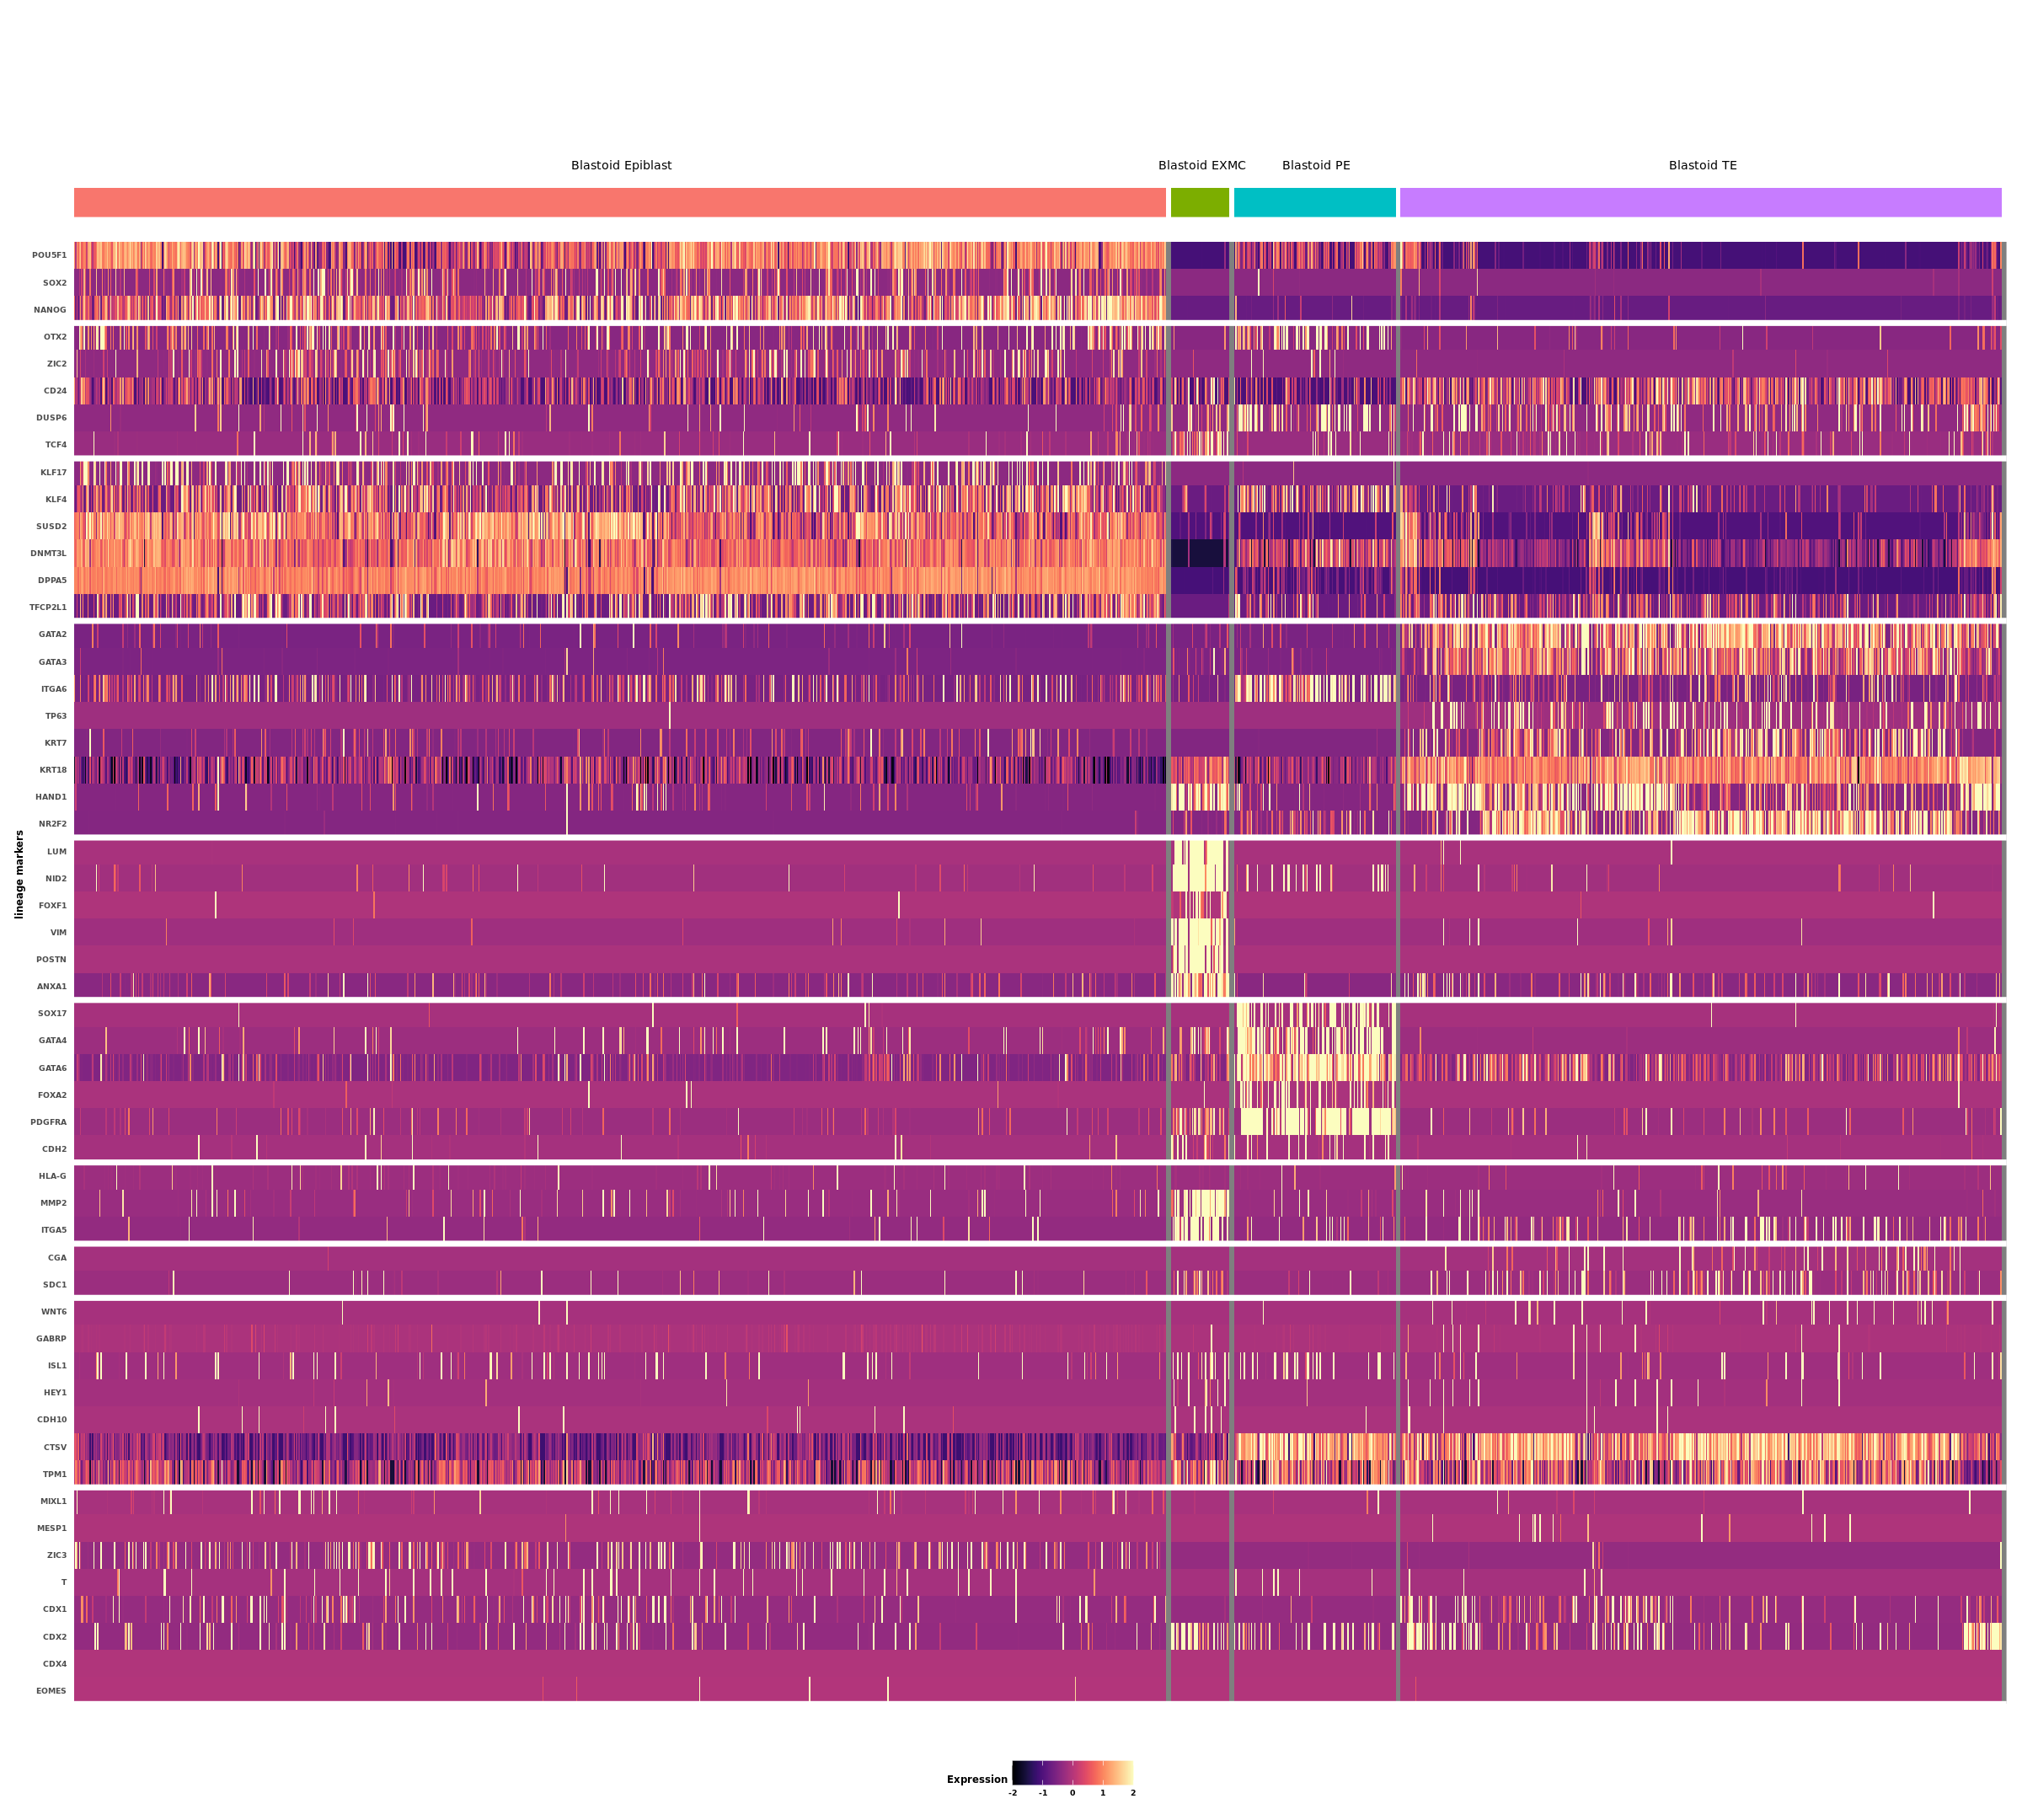

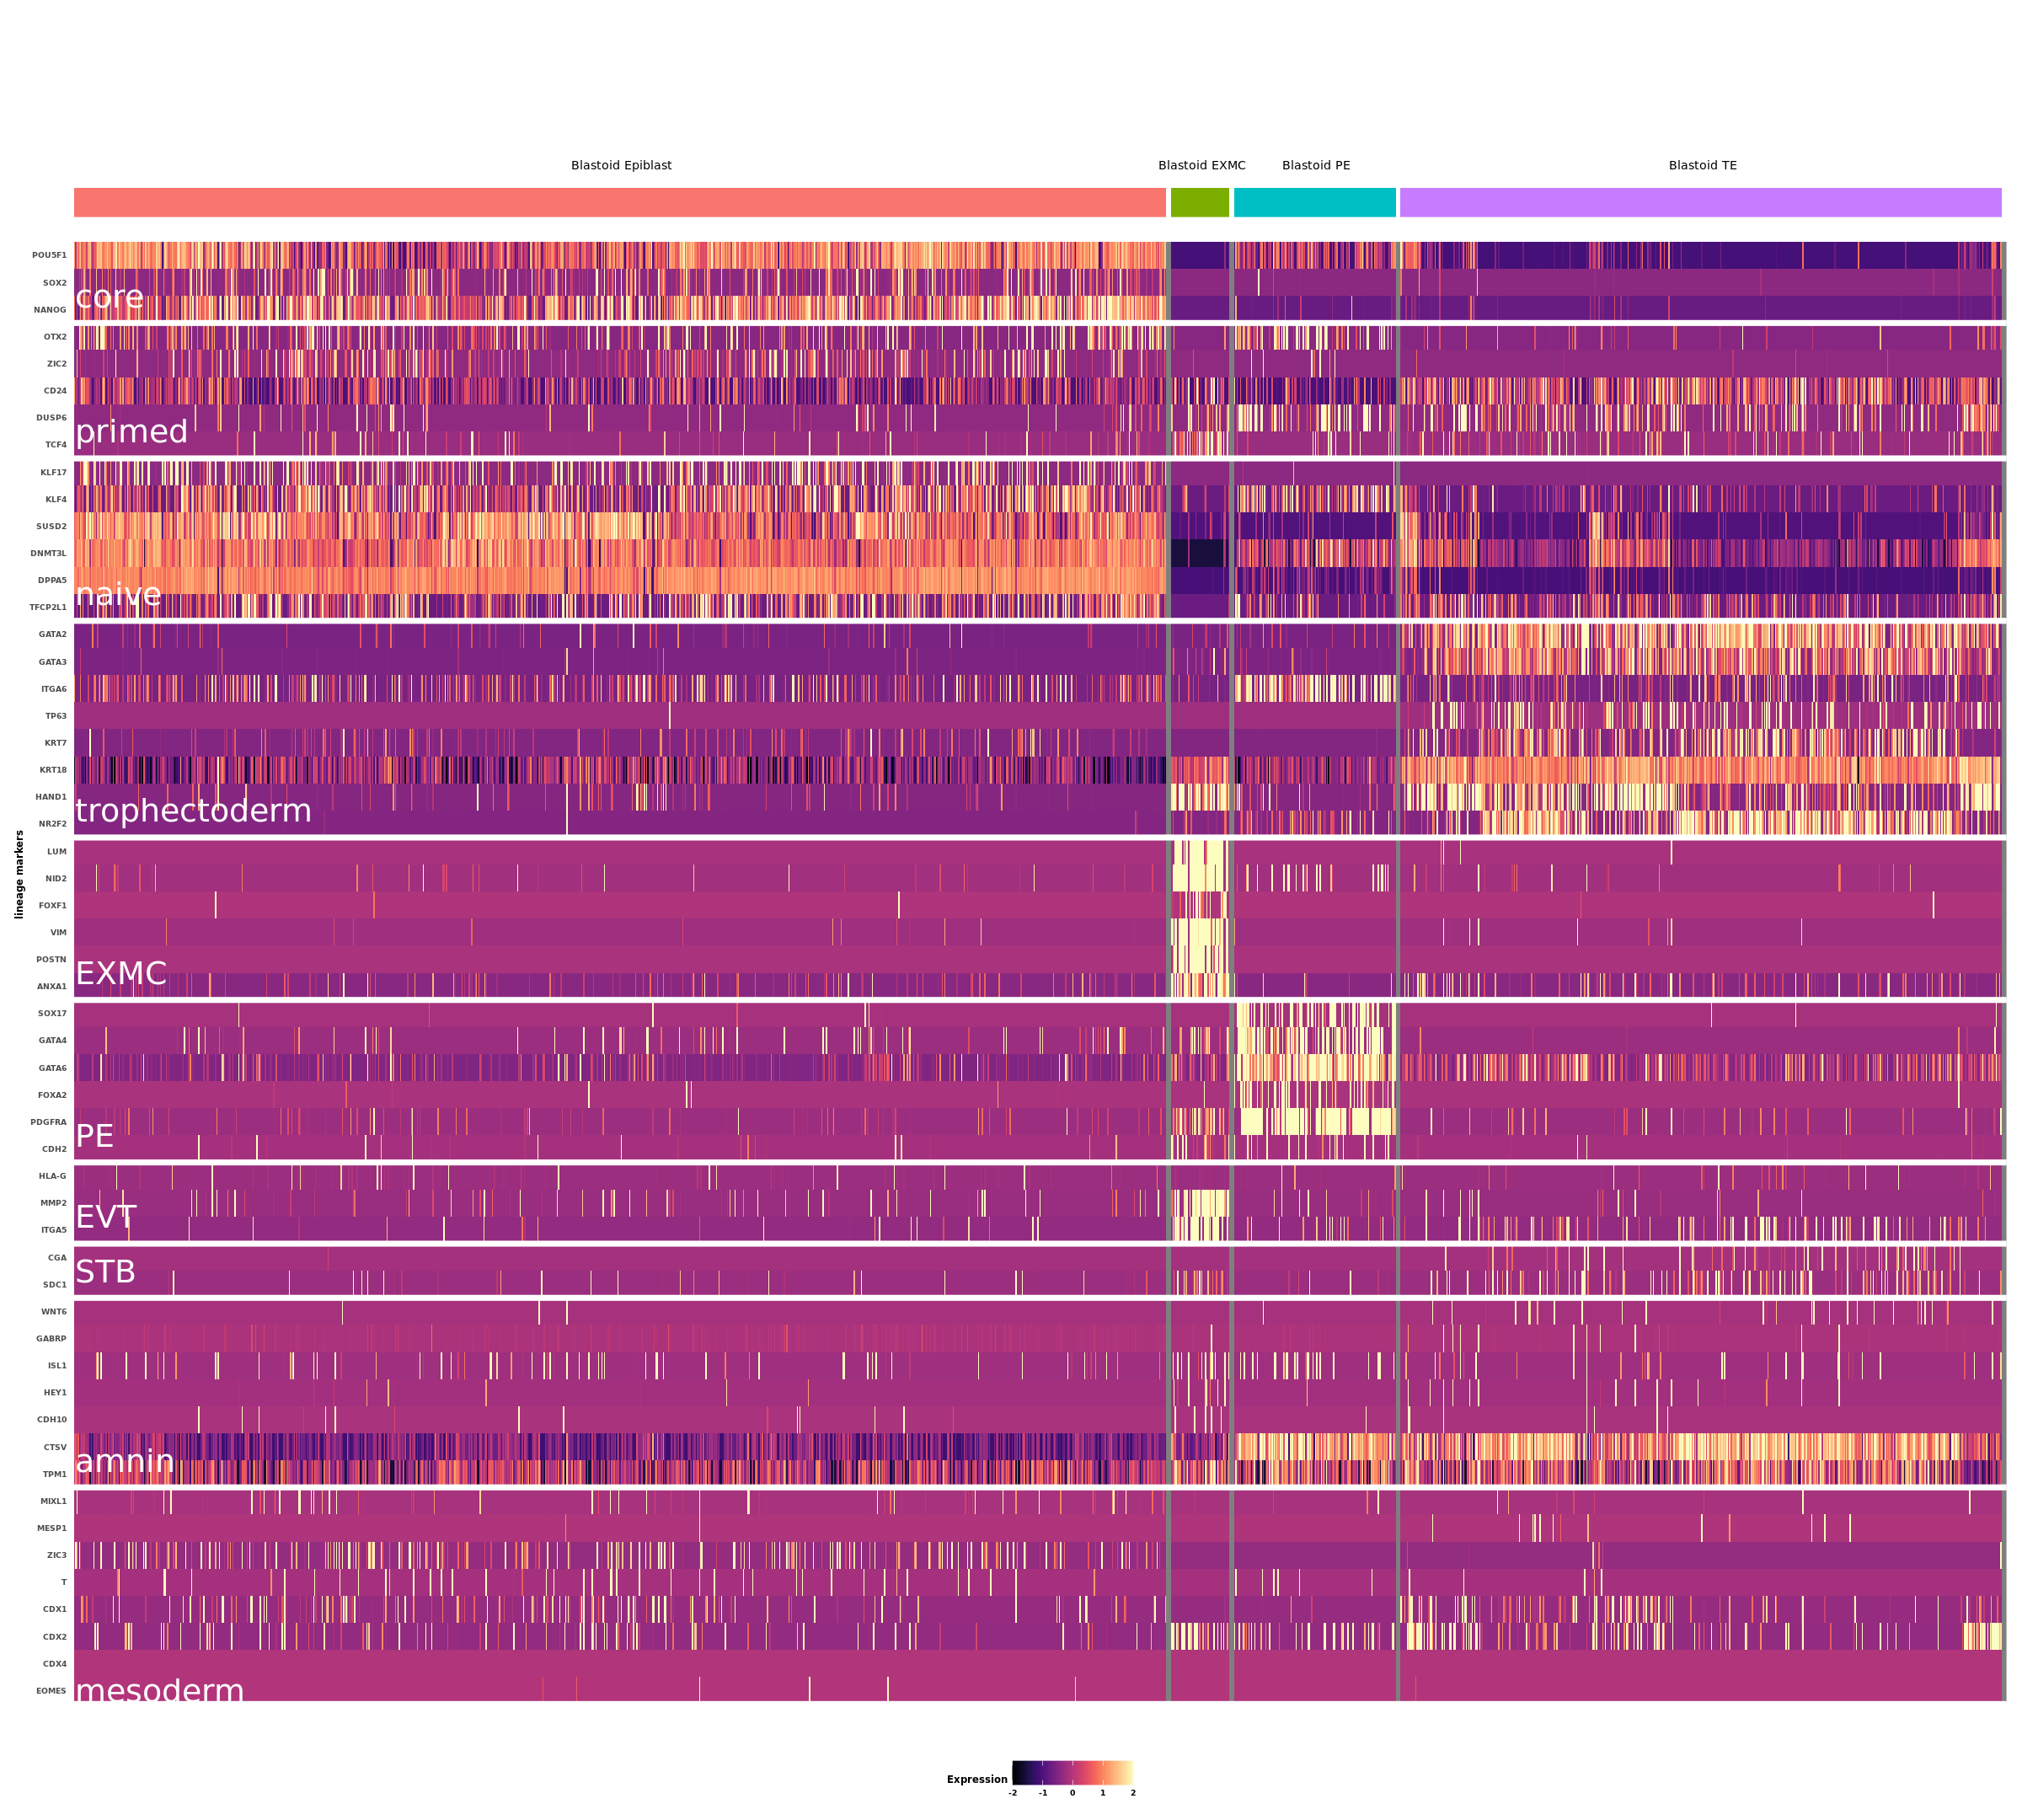

In [ ]:
plotHeatmap(subset(indSeurats[[11]], cells = which(indSeurats[[11]]@meta.data$finalLabels%in%c("Blastoid Epiblast", "Blastoid EXMC", "Blastoid PE", "Blastoid TE"))), group.by="finalLabels", feats = combinedFeats,  topTextAngle = 0, dMin=-2, dMax=2)

<h2> trying clustering prior to heatmap </h2>

In [42]:
temp <-indSeurats[[11]]@assays$RNA@scale.data[, which(colnames(indSeurats[[11]]@assays$RNA@scale.data)%in%indSeurats[[11]]@meta.data$cell[which(!is.na(indSeurats[[11]]@meta.data$finalLabels))])]
temp[which(temp>2)] <- 2
temp[which(temp< -2)] <- -2

In [43]:
clust =hclust(d=dist(x =t(temp), method="euclidean"))

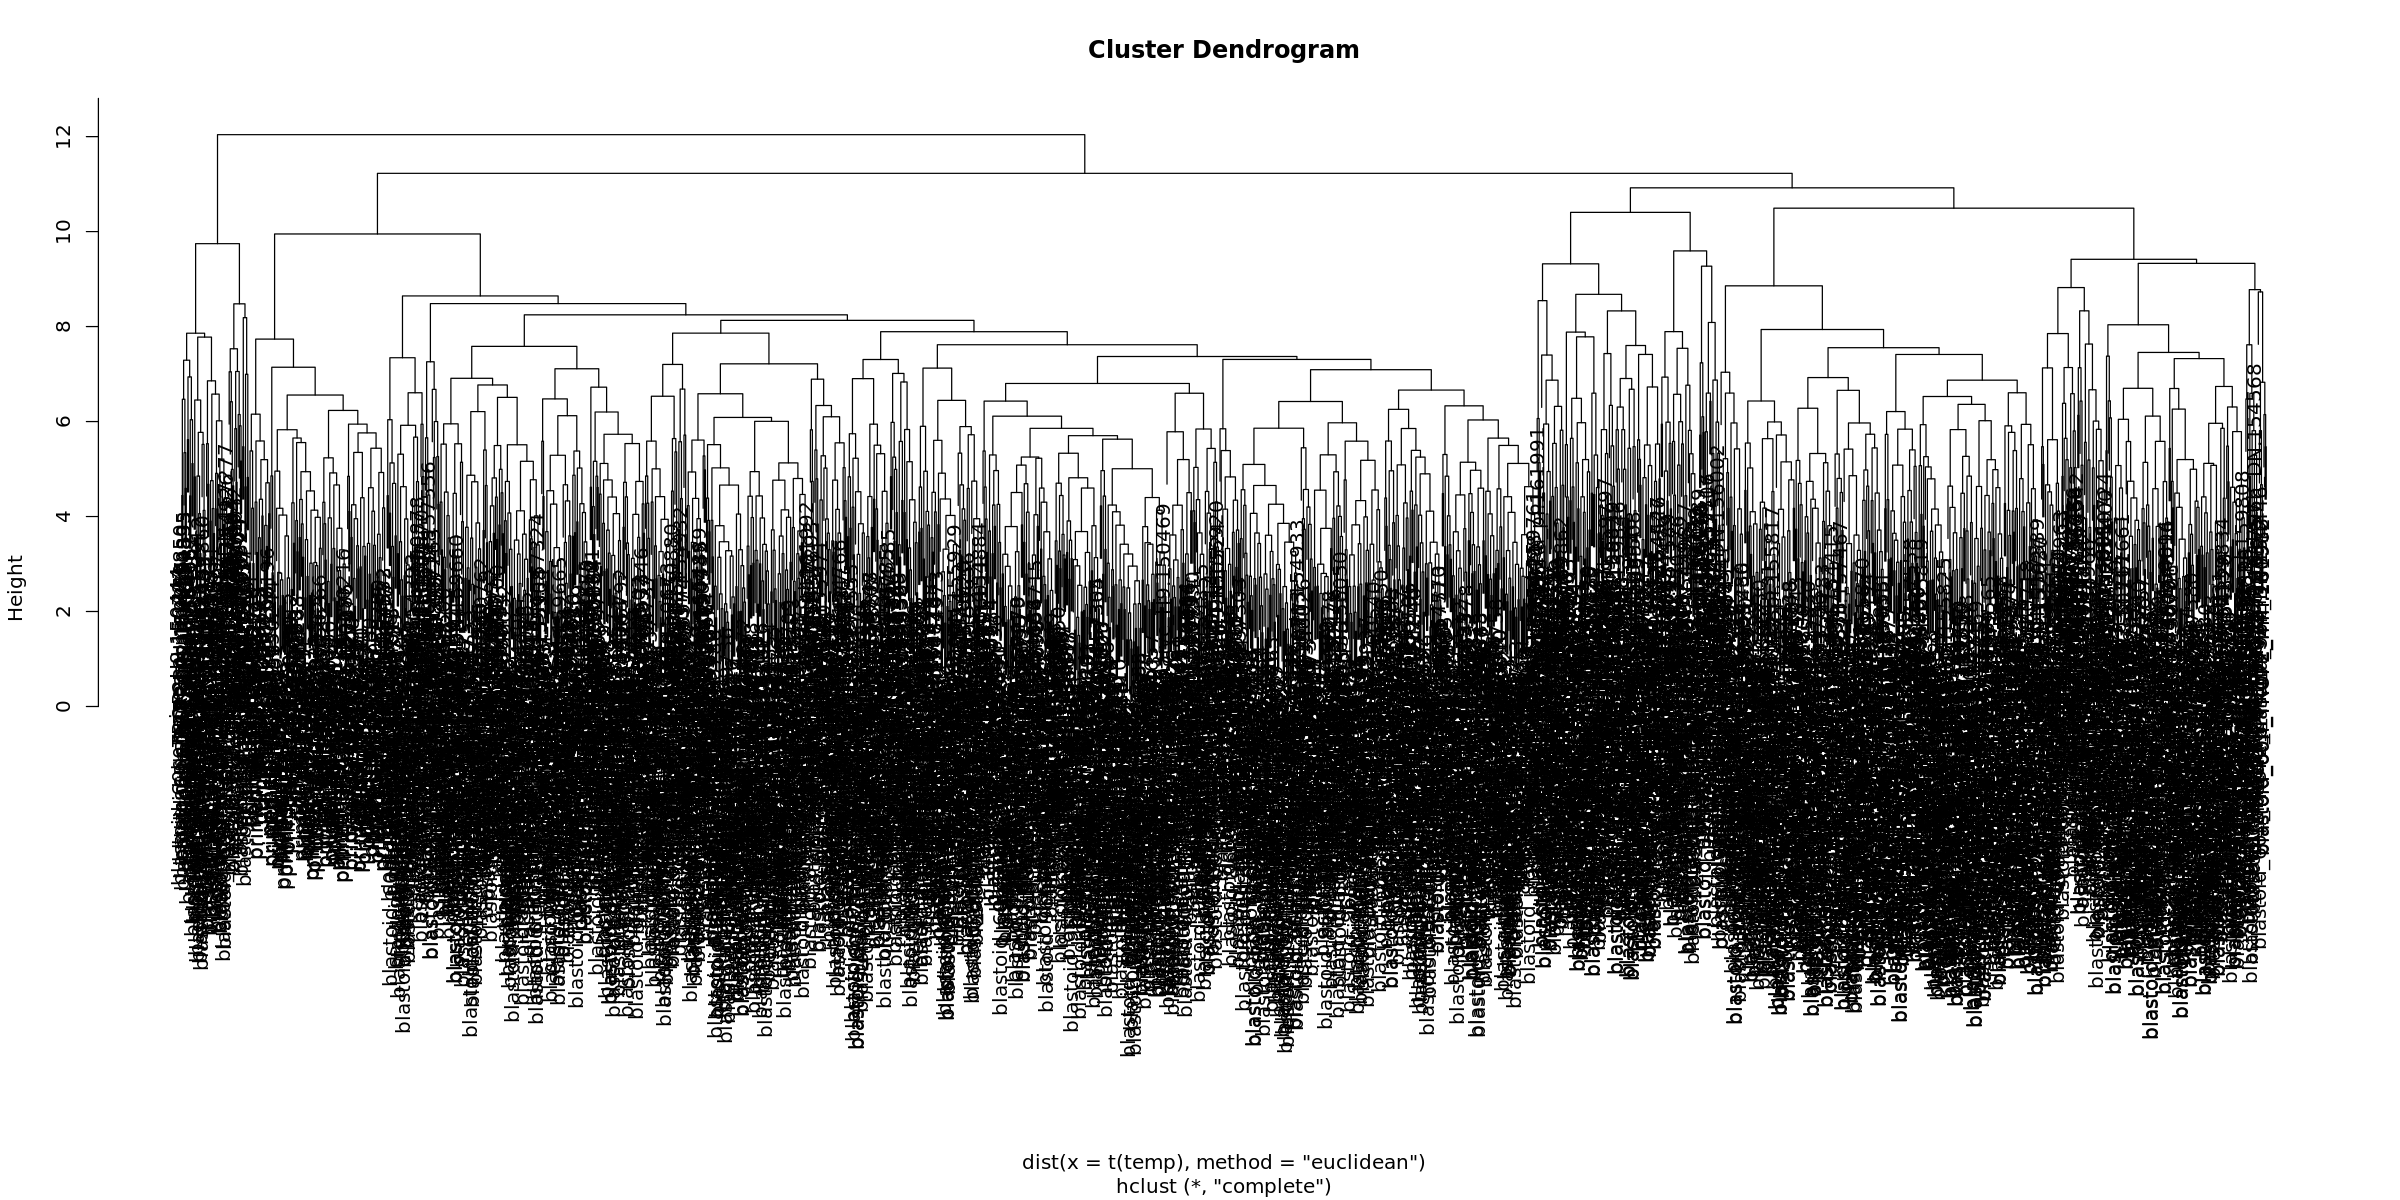

In [44]:
options(repr.plot.width=20, repr.plot.height=10)
plot(clust)

In [45]:
customHeatmapData <- data.frame(order=1:length(clust$order), type=indSeurats[[11]]@meta.data$finalLabels[which(colnames(indSeurats[[11]]@assays$RNA@scale.data)%in%indSeurats[[11]]@meta.data$cell[which(!is.na(indSeurats[[11]]@meta.data$finalLabels))])][clust$order], 
                                data=stack(as.data.frame(t(indSeurats[[11]]@assays$RNA@scale.data[, which(colnames(indSeurats[[11]]@assays$RNA@scale.data)%in%indSeurats[[11]]@meta.data$cell[which(!is.na(indSeurats[[11]]@meta.data$finalLabels))])][,clust$order]))),
                               cell=indSeurats[[11]]@meta.data$cell[which(colnames(indSeurats[[11]]@assays$RNA@scale.data)%in%indSeurats[[11]]@meta.data$cell[which(!is.na(indSeurats[[11]]@meta.data$finalLabels))])][clust$order])

In [46]:
customHeatmapData$data.ind <- factor(customHeatmapData$data.ind, levels=unlist(combinedFeats)[which(unlist(combinedFeats)%in%unique(customHeatmapData$data.ind))])

In [47]:
customHeatmapData$scaled.data <- customHeatmapData$data.values
customHeatmapData$scaled.data[which(customHeatmapData$data.values>2)] <- 2
customHeatmapData$scaled.data[which(customHeatmapData$data.values < -2)] <- -2

In [48]:
divLines <- c()
count=0
for(i in 1:length(combinedFeats)){
        divLines <- c(divLines, count+length(which(combinedFeats[[i]]%in%customHeatmapData$data.ind))+0.5)
        count=count+length(which(combinedFeats[[i]]%in%customHeatmapData$data.ind))
    
}


In [49]:
divLines

[1]  3.5  8.5 14.5 22.5 28.5 34.5 37.5 39.5 46.5 54.5

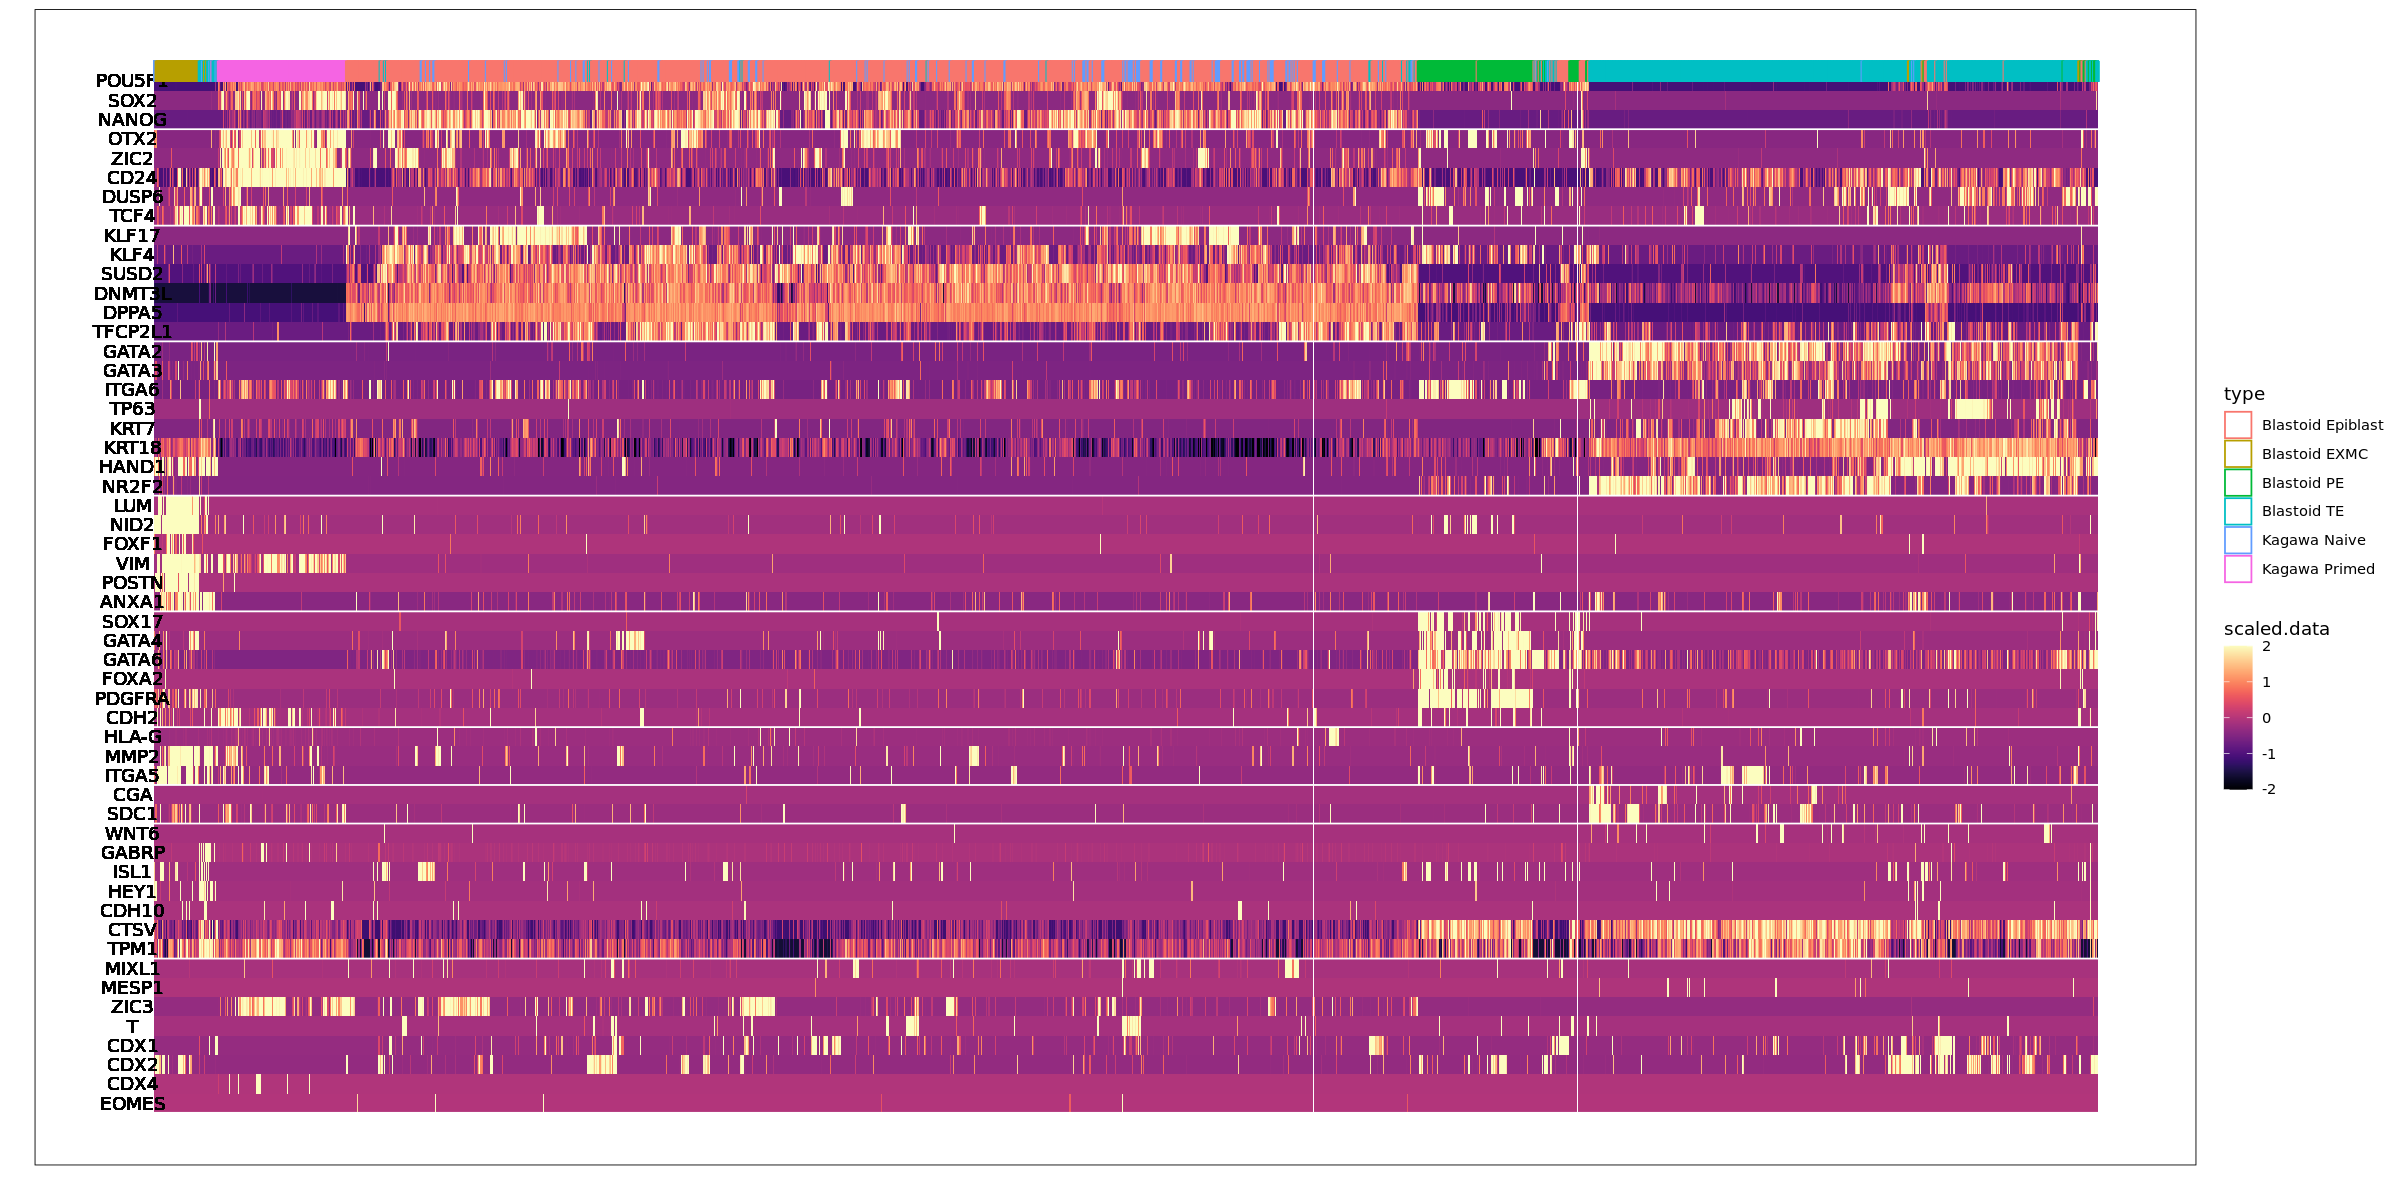

In [50]:
ggplot(customHeatmapData, aes(xmin=order-0.5, xmax=order+0.5, fill=scaled.data, ymin=56-as.numeric(data.ind)-0.5, ymax=56-as.numeric(data.ind)+0.5))+
geom_rect()+geom_text(aes(x=-20, y=56-as.numeric(data.ind), label=data.ind))+scale_fill_viridis(option = "A")+
geom_rect(aes(ymin=max(as.numeric(data.ind))+1, ymax=max(as.numeric(data.ind))+2, color=type), alpha=0)+theme_linedraw()+
theme(panel.grid = element_blank(), axis.line = element_blank(), axis.text=element_blank(), axis.ticks=element_blank())+xlab("")+ylab("")+
geom_hline(yintercept = 56-divLines, color="white")

<h2>Clustering per cell type as a function </h>


In [57]:
clusterPerCellType <- function(cellType, addClust=0){
    temp <-indSeurats[[11]]@assays$RNA@scale.data[, which(colnames(indSeurats[[11]]@assays$RNA@scale.data)%in%indSeurats[[11]]@meta.data$cell[which(indSeurats[[11]]@meta.data$finalLabels%in%cellType)])]

    
    clust =hclust(d=dist(x =t(temp), method="euclidean"))
    
    customHeatmapData <- data.frame(order=1:length(clust$order), type=indSeurats[[11]]@meta.data$finalLabels[which(colnames(indSeurats[[11]]@assays$RNA@scale.data)%in%indSeurats[[11]]@meta.data$cell[which(indSeurats[[11]]@meta.data$finalLabels%in%cellType)])][clust$order], 
                                data=stack(as.data.frame(t(indSeurats[[11]]@assays$RNA@scale.data[, which(colnames(indSeurats[[11]]@assays$RNA@scale.data)%in%indSeurats[[11]]@meta.data$cell[which(indSeurats[[11]]@meta.data$finalLabels%in%cellType)])][,clust$order]))),
                               cell=indSeurats[[11]]@meta.data$cell[which(colnames(indSeurats[[11]]@assays$RNA@scale.data)%in%indSeurats[[11]]@meta.data$cell[which(indSeurats[[11]]@meta.data$finalLabels%in%cellType)])][clust$order])
    
    customHeatmapData$data.ind <- factor(customHeatmapData$data.ind, levels=unlist(combinedFeats)[which(unlist(combinedFeats)%in%unique(customHeatmapData$data.ind))])
    
    customHeatmapData$scaled.data <- customHeatmapData$data.values
    customHeatmapData$scaled.data[which(customHeatmapData$data.values>2)] <- 2
    customHeatmapData$scaled.data[which(customHeatmapData$data.values < -2)] <- -2
    
    #adding the length of previous clusters to order so that it will be able to be combined
    customHeatmapData$order <- customHeatmapData$order+addClust
    
    return(customHeatmapData)
}

In [58]:
customHeatMapPerCellType <- clusterPerCellType("Blastoid Epiblast")

divVertLine <- c(max(customHeatMapPerCellType$order))

for(i in c( "Blastoid PE","Blastoid EXMC","Blastoid TE")){
    
            customHeatMapPerCellType <- rbind(clusterPerCellType(i, addClust=max(customHeatMapPerCellType$order)),
                                             customHeatMapPerCellType)

    divVertLine <- c(divVertLine,max(customHeatMapPerCellType$order))

  
    
}


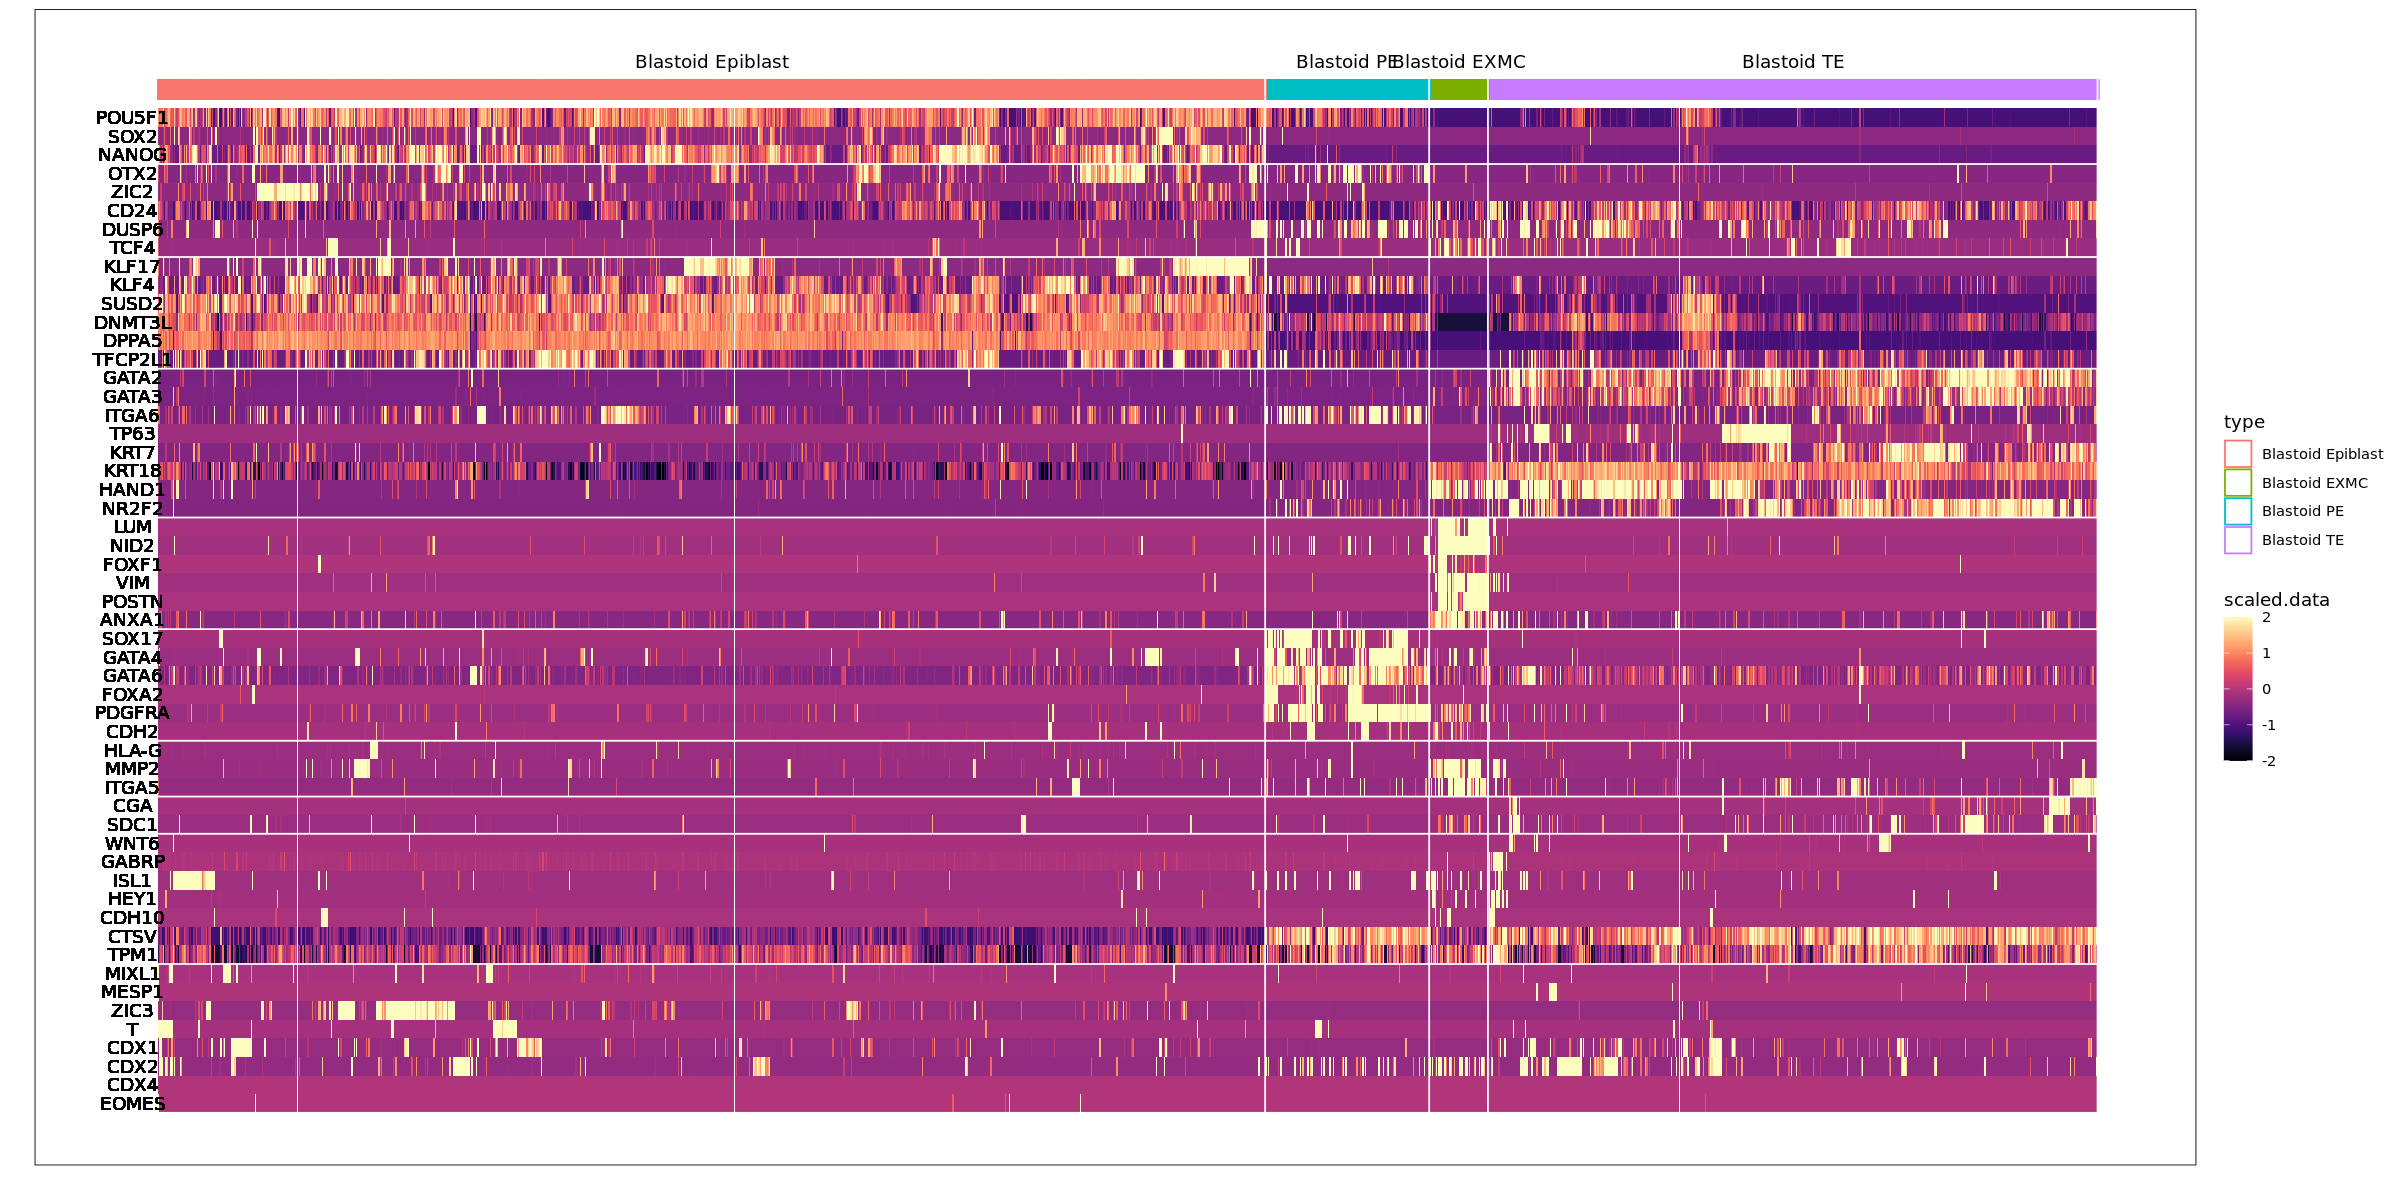

In [ ]:
topLabels <- data.frame(topLabel=unique(customHeatMapPerCellType$type),
                       xCoord=NA, yCoord=58)

for(i in 1:nrow(topLabels)){
    topLabels$xCoord[i] <- mean(customHeatMapPerCellType$order[which(customHeatMapPerCellType$type==topLabels$topLabel[i])])
}


ggplot(customHeatMapPerCellType)+
geom_rect(aes(xmin=order-0.5, xmax=order+0.5, fill=scaled.data, ymin=56-as.numeric(data.ind)-0.5, ymax=56-as.numeric(data.ind)+0.5))+
scale_fill_viridis(option = "A")+
geom_rect(aes(xmin=order-0.5, xmax=order+0.5, ymin=max(as.numeric(data.ind))+2, ymax=max(as.numeric(data.ind))+3, color=type), alpha=0)+theme_linedraw()+
theme(panel.grid = element_blank(), axis.line = element_blank(), axis.text=element_blank(), axis.ticks=element_blank())+xlab("")+ylab("")+
geom_vline(xintercept = divVertLine, color="white")+
geom_hline(yintercept = 56-divLines, color="white")+
geom_text(aes(x=-20, y=56-as.numeric(data.ind), label=data.ind))+
geom_text(data=topLabels, aes(x=xCoord, y=yCoord, label=topLabel), color="black")

In [ ]:
topLabels$topLabel <- c("TE", "EXMC", "PrE", "Epiblast")

In [ ]:
topLabels

topLabel,xCoord,yCoord
<chr>,<dbl>,<dbl>
TE,1336.5,58
EXMC,1063.5,58
PrE,972.5,58
Epiblast,453.0,58


In [ ]:
pdf(paste(c(outFilePrefix, "clusteredHeatMapBlastoid.pdf"), collapse=""), width=8.3, height=5)
ggplot(customHeatMapPerCellType)+
geom_rect(aes(xmin=order-0.5, xmax=order+0.5, fill=scaled.data, ymin=56-as.numeric(data.ind)-0.5, ymax=56-as.numeric(data.ind)+0.5))+
scale_fill_viridis(option = "A")+
geom_rect(aes(xmin=order-0.5, xmax=order+0.5, ymin=max(as.numeric(data.ind))+2, ymax=max(as.numeric(data.ind))+3, color=type), alpha=0)+theme_linedraw()+
theme(panel.grid = element_blank(), axis.line = element_blank(), axis.text=element_blank(), axis.ticks=element_blank())+xlab("")+ylab("")+
geom_vline(xintercept = divVertLine, color="white")+
geom_hline(yintercept = 56-divLines, color="white")+
geom_text(aes(x=-20, y=56-as.numeric(data.ind), label=data.ind))+
geom_text(data=topLabels, aes(x=xCoord, y=yCoord, label=topLabel), color="black")
dev.off()

png 
  2

In [ ]:
jpeg(paste(c(outFilePrefix, "clusteredHeatMapBlastoid.jpeg"), collapse=""), width=1920, height=1080)
ggplot(customHeatMapPerCellType)+
geom_rect(aes(xmin=order-0.5, xmax=order+0.5, fill=scaled.data, ymin=56-as.numeric(data.ind)-0.5, ymax=56-as.numeric(data.ind)+0.5))+
scale_fill_viridis(option = "A")+
geom_rect(aes(xmin=order-0.5, xmax=order+0.5, ymin=max(as.numeric(data.ind))+2, ymax=max(as.numeric(data.ind))+3, color=type), alpha=0)+theme_linedraw()+
theme(panel.grid = element_blank(), axis.line = element_blank(), axis.text=element_blank(), axis.ticks=element_blank())+xlab("")+ylab("")+
geom_vline(xintercept = divVertLine, color="white")+
geom_hline(yintercept = 56-divLines, color="white")+
geom_text(aes(x=-20, y=56-as.numeric(data.ind), label=data.ind))+
geom_text(data=topLabels, aes(x=xCoord, y=yCoord, label=topLabel), color="black")
dev.off()

png 
  2